# Magic data analysis

### Description

The data are Monte Carlo generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

### Dataset

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.


### References

[1] Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. 
Nucl.Instr.Meth. A, 516, pp. 511-528. 

[2] P. Savicky, E. Kotrc. 
Experimental Study of Leaf Confidences for Random Forest. 
Proceedings of COMPSTAT 2004, In: Computational Statistics. (Ed.: Antoch J.) - Heidelberg, Physica Verlag 2004, pp. 1767-1774. 

[3] J. Dvorak, P. Savicky. 
Softening Splits in Decision Trees Using Simulated Annealing. 
Proceedings of ICANNGA 2007, Warsaw, (Ed.: Beliczynski et. al), Part I, LNCS 4431, pp. 721-729.

[4] Aharonian, F. et al.
The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes
Astrophys. J. 539 (2000) 317-324

[5] Aleksic, J. et al.
Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes
Journal of High Energy Astrophysics, 5–6 (2015) 30-38.

In [197]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import linalg as la 
from scipy import integrate
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.decomposition import PCA
import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import uncertainties as un


In [2]:
# PLOT CODE

def features_plot(df1, df2, features, plot_type):

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(40,15))

    if plot_type == 'analysis':
        udm = ['fLength (mm)', 'fWidth (mm)', 'fSize (#photons)', 'fConc (#photons ratio)', 'fConc1 (#photons ratio)', 'fAsym (mm)', 'fM3Long (mm)', 'fM3Trans (mm)', 'fAlpha (degrees)', 'fDist (mm)']
    elif plot_type == 'PCA':
        udm = [f'PC: {i}' for i in range(1, 11)]

    bins = 50

    for i in range(2):
        for j in range(5):
            if df1[features[5*i+j]].std() < 1:
                siglabel = f'signal mean: {df1[features[5*i+j]].mean():.2f}±{df1[features[5*i+j]].std():.2f}'
                bkglabel = f'bkg mean: {df2[features[5*i+j]].mean():.2f}±{df2[features[5*i+j]].std():.2f}'
            else:
                siglabel = f'signal mean: {df1[features[5*i+j]].mean():.0f}±{df1[features[5*i+j]].std():.0f}'
                bkglabel = f'bkg mean: {df2[features[5*i+j]].mean():.0f}±{df2[features[5*i+j]].std():.0f}'

            counts_sig, _ = np.histogram(df1[features[5*i+j]], bins = bins, density=True)
            counts_bkg, _ = np.histogram(df2[features[5*i+j]], bins = bins, density=True)

            ax[i][j].hist(x=df1[features[5*i+j]], bins = bins, density=True, alpha = 0.6, color='C1')
            ax[i][j].hist(x=df2[features[5*i+j]], bins = bins, density=True, alpha = 0.5, color = 'C0')

            ax[i][j].vlines(x=df1[features[5*i+j]].mean(), ymin=0, ymax=counts_sig.max(), label=siglabel, color = 'C1')
            ax[i][j].vlines(x=df2[features[5*i+j]].mean(), ymin=0, ymax=
            counts_bkg.max(), label=bkglabel, color = 'C0')

            ax[i][j].set_xlabel(udm[5*i+j], fontsize=18)
            ax[i][j].set_ylabel('pdf', fontsize=16)
            ax[i][j].tick_params(axis='both', which='major', labelsize=14)
            ax[i][j].legend(loc='best', fontsize=18)

    plt.show()

### 1. Study of the dataset features and comparison between signal and background events

After loading the dataset and changing the `class` label with:
* 1 if the data are generated as signal events
* 0 if the data are generated as background events
  
We then separate the data according to their class in order to study their features both for signal and background. For each feature we compute its mean and standard deviation and compare them for the two classes.

In [3]:
# read and import data
data = pd.read_csv('magic04.data')
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
data.columns = features

# converting sig to 1 and bkg to 0
data_c = data.copy(deep=True)
data_c['class'] = np.where(data['class']=='g',1,0)

Y = data_c['class']

data_c.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,1
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.788,1
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.737,1
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.462,1
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.098,1


In [4]:
# dataset dimension and label frequencies
print('Dataset dimension:', data.shape)
ylab, yfreq = np.unique(Y, return_counts=True)
print('Labels and their relative frequencies:')
print(f' - background:\tlabel {ylab[0]} \t {100*yfreq[0]/data.shape[0]:.2f}%')
print(f' - signal:\tlabel {ylab[1]} \t {100*yfreq[1]/data.shape[0]:.2f}%')

Dataset dimension: (19019, 11)
Labels and their relative frequencies:
 - background:	label 0 	 35.16%
 - signal:	label 1 	 64.84%


As we can observe, the dataset is very asymmetric with respect to the number of data that compose signal and background: almost 2/3 is labelled as "signal". This dataset is in fact constructed underestimating the number of background events, since real data would contain mainly background events.

In [5]:
# separating signal and bkg data
datasig = data_c[data_c['class']==1]
databkg = data_c[data_c['class']==0]

datasig = datasig.drop(columns='class')
databkg = databkg.drop(columns='class')

#### 1.1 Camera plane reconstruction

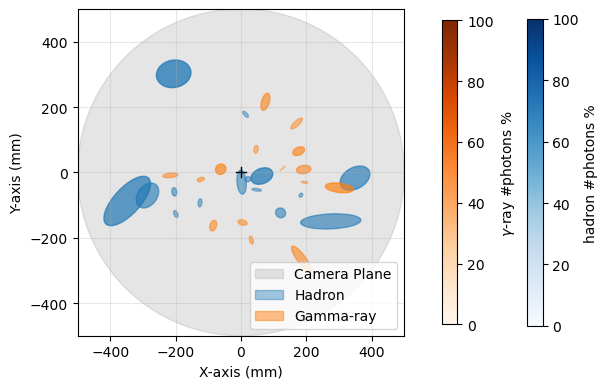

In [221]:
# visualize data
n_ellipses = 15

# ellipse parameters
random_angle_sig = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
sig_idx = np.random.randint(0,10000, size=n_ellipses)
sig_ellipse_params = [ 
    {
        'center': (datasig['fDist'][idx] * np.cos(random_angle_sig[i]), datasig['fDist'][idx] * np.sin(random_angle_sig[i])),  
        'width': datasig['fWidth'][idx], 
        'height': datasig['fLength'][idx], 
        'angle': datasig['fAlpha'][idx],
        'alpha': datasig['fSize'][idx]/data_c['fSize'].max()
        } 
    for i, idx in enumerate(sig_idx)
    ]

random_angle_bkg = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
bkg_idx = np.random.randint(13000,19000, size=n_ellipses)
bkg_ellipse_params = [ 
    {
        'center': (databkg['fDist'][idx] * np.cos(random_angle_bkg[i]), databkg['fDist'][idx] * np.sin(random_angle_bkg[i])),
        'width': databkg['fWidth'][idx], 
        'height': databkg['fLength'][idx], 
        'angle': databkg['fAlpha'][idx],
        'alpha': databkg['fSize'][idx]/data_c['fSize'].max()
        } 
    for i, idx in enumerate(bkg_idx)
    ]

fig, ax = plt.subplots(figsize=(6,8))

ax.grid(alpha=0.3)

# plot ellipses
radius = 500
camera_circle = patches.Circle((0,0), radius, alpha=0.2, color='grey')
ax.add_patch(camera_circle)

bkg_ellipses = []
sig_ellipses = []

for params in bkg_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'], 
        width=params['width'], 
        height=params['height'], 
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi), 
        fill=True, 
        alpha=params['alpha'], 
        color='C0'
        )
    ax.add_patch(ellipse)
    bkg_ellipses.append(ellipse)

for params in sig_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'], 
        width=params['width'], 
        height=params['height'], 
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi),
        alpha=params['alpha'], 
        color='C1'
        )
    ax.add_patch(ellipse)
    sig_ellipses.append(ellipse)

ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_aspect('equal')

legend_labels = ['Camera Plane', 'Hadron', 'Gamma-ray']
legend_handles = [camera_circle, bkg_ellipses[0], sig_ellipses[0]]
ax.legend(legend_handles, legend_labels, loc='lower right')

center_cross_size = 15
ax.plot([0, 0], [-center_cross_size, center_cross_size], color='black', linewidth=1)
ax.plot([-center_cross_size, center_cross_size], [0, 0], color='black', linewidth=1)

# color scale indicating alpha for background ellipses
bkg_alphas = [params['alpha'] for params in bkg_ellipse_params]
bkg_norm = Normalize(vmin=0, vmax=100)
bkg_scalar_map = ScalarMappable(norm=bkg_norm, cmap='Blues')
bkg_scalar_map.set_array(bkg_alphas)
bkg_colorbar = plt.colorbar(bkg_scalar_map, ax=ax, fraction=0.033, pad = 0.15)
bkg_colorbar.set_label('hadron #photons %')

# color scale indicating alpha for signal ellipses
sig_alphas = [params['alpha'] for params in sig_ellipse_params]
sig_norm = Normalize(vmin=0, vmax=100)
sig_scalar_map = ScalarMappable(norm=sig_norm, cmap='Oranges')
sig_scalar_map.set_array(sig_alphas)
sig_colorbar = plt.colorbar(sig_scalar_map, ax=ax, fraction=0.04, pad = 0.1)
sig_colorbar.set_label('$\gamma$-ray #photons %')

ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')

plt.show()

The previous plot is a reconstruction of the traces detected from the telescope camera: the orange ellipses represent the Cherenkov photons coming from primary gamma rays and the blue ones are the photons generated by hadron showers. The data differentiates also for the number of photons inside each ellipses; this value is shown in the colorbars in the side of the image. \
It can be noticed that the orange ellipses are mostly radially oriented: this means that the shower axis is parallel to the telescope's optical axis [1]. The orientation of the background ellipses, instead, is more random since the noise comes from various sources.

#### 1.2 Feature analysis

In the following plot are represented the distributions of every feature superimposing the data of signal and background. For each distribution it is shown the value of its mean as well as its standard deviation.

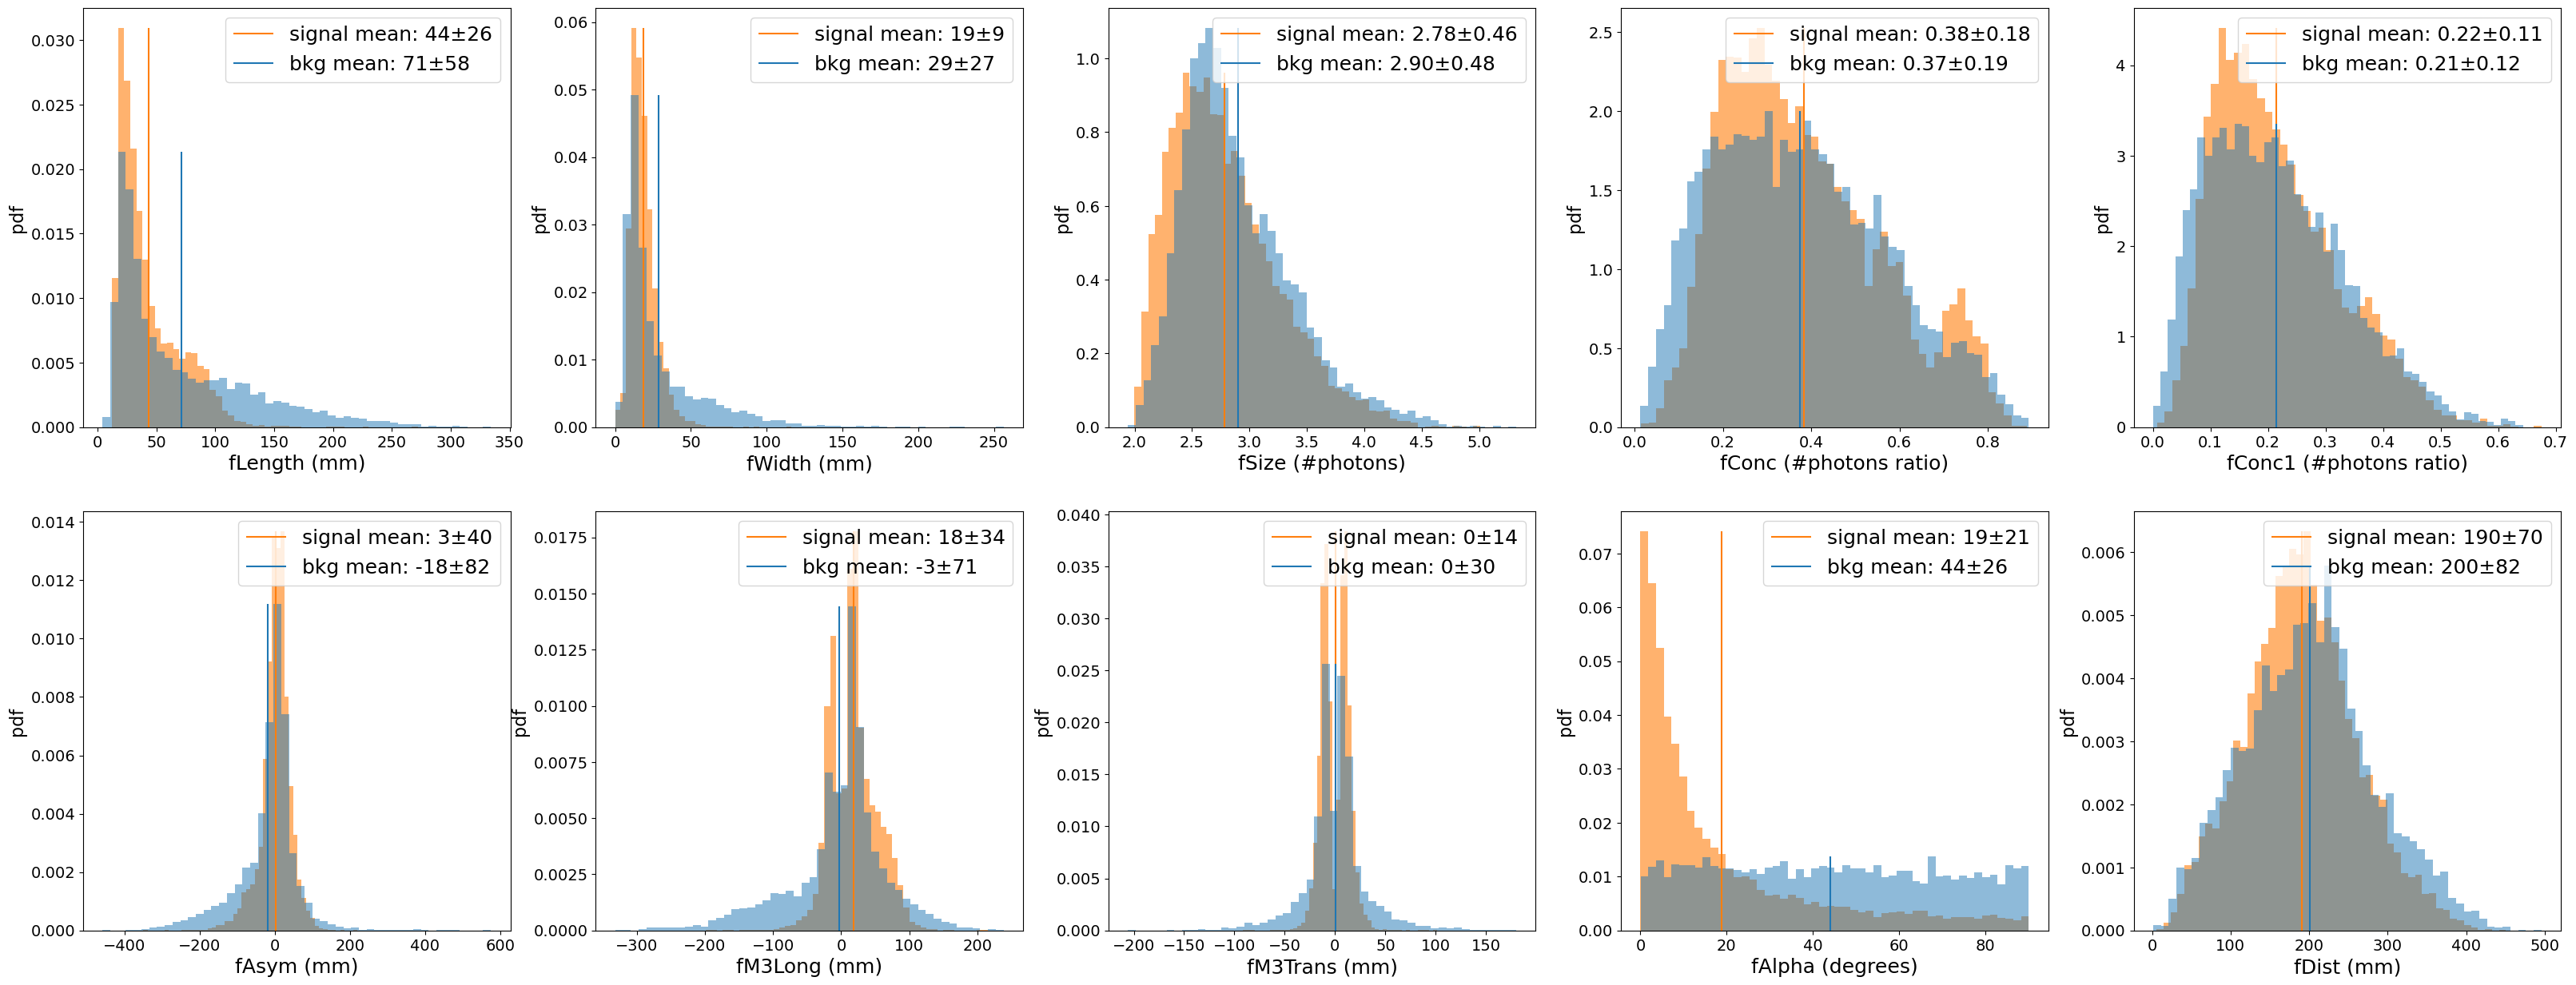

In [7]:
# feature distribution plot

features_plot(datasig, databkg, features, plot_type='analysis')

It can be observed that the mean values of all the features coming from signal and background are compatible. They also distribute with the same shape for all the features a part from `fAlpha`. Therefore it is not possible to distinguish signal from background clearly from feature distributions.\
For the latter in fact the two classes follow two different distributions: the angles of the background are uniformly spread from 0° to 90°, while the values of `fAlpha` from signal events are instead peaked around small values of alpha, as can be also seen in the previous shower reconstruction. The spread of every distribution is in general bigger for the background data.

It can also be noticed that the parameters `fM3Long` and `fM3Trans` follow a bimodal distribution with two peaks, but centered in 0. These parameters essentially represent the asymmetry of the images on the camera plane with respect to major and minor axis. We can thus conclude that the images are skewed in both directions and few images are symmetric.

### 2. Study of the correlations between dataset feature separately for signal and background events

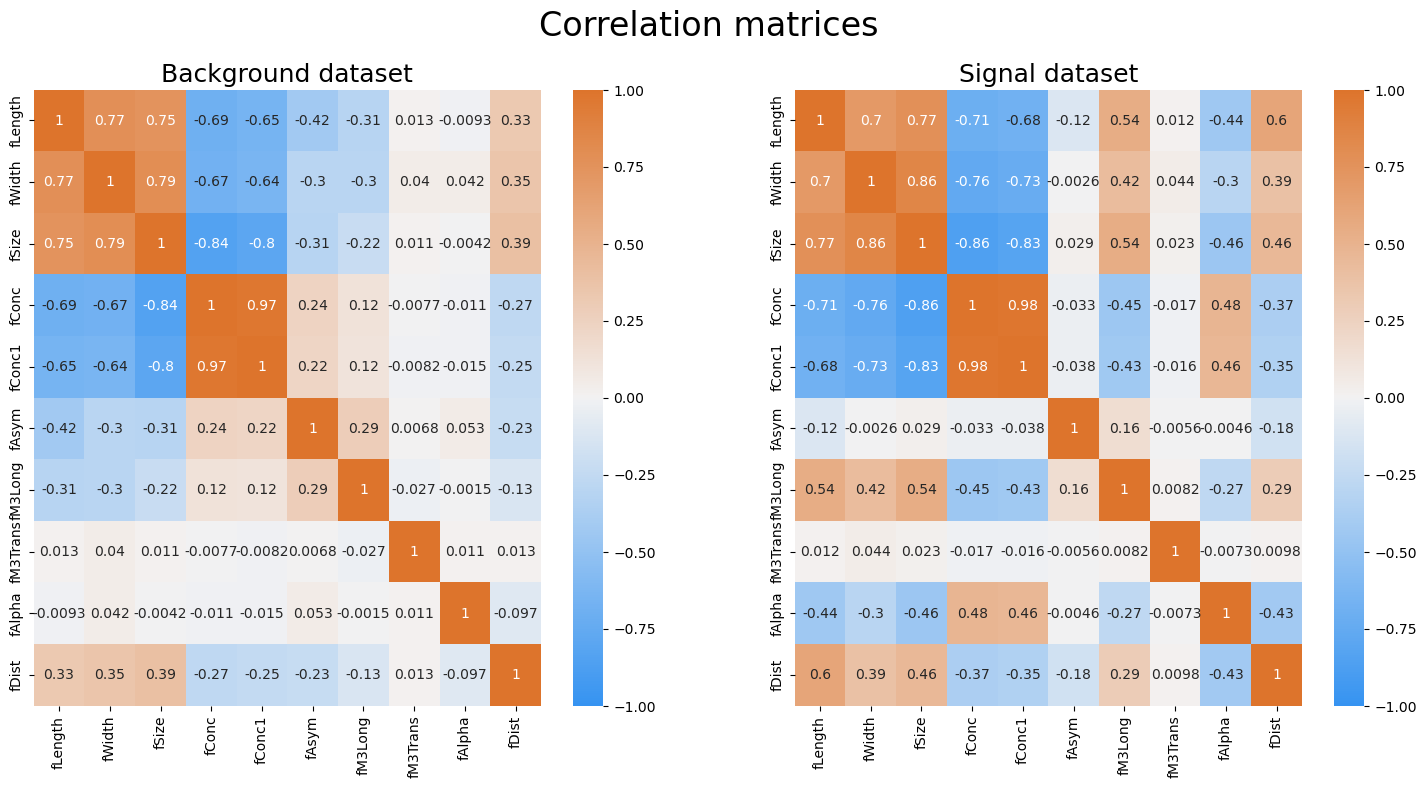

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

fig.suptitle('Correlation matrices', fontsize=24)
cmapp = sns.diverging_palette(250, 30, l=60, s=90, center="light", as_cmap=True)
sns.heatmap(databkg.corr(), annot=True, vmin=-1, vmax=1, ax=ax[0], cmap=cmapp)
sns.heatmap(datasig.corr(), annot=True, vmin=-1, vmax=1, ax=ax[1], cmap=cmapp)

ax[0].set_title('Background dataset', fontsize=18)
ax[1].set_title('Signal dataset', fontsize=18)

plt.show()

It can be seen that the most correlated features are the first five. Looking at these, the correlation of the first three is positive, instead the one of `fConc1` and `fConc2` with respect to the others is negative, in agreement both for signal and background. We can also notice that the correlation between `fConc1` and fConc2 is very close to 1, according to the fact that the value of `fConc2` is essentially derived from `fConc1`.\
The differences in the correlations for the two classes can be seen in the following features:
- `fAsym`: this feature is slightly more correlated to the others for background events, for signal instead the correlation is null;
- `fM3Long`: the sign of the correlation values computed for this feature is swapped for signal and background;
- `fAlpha`: the values of the angles fAlpha are more correlated to the other features in the case of signal events, for background events instead the correlation is null.

The following plot helps to better visualize the correlation of the first five features.

/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


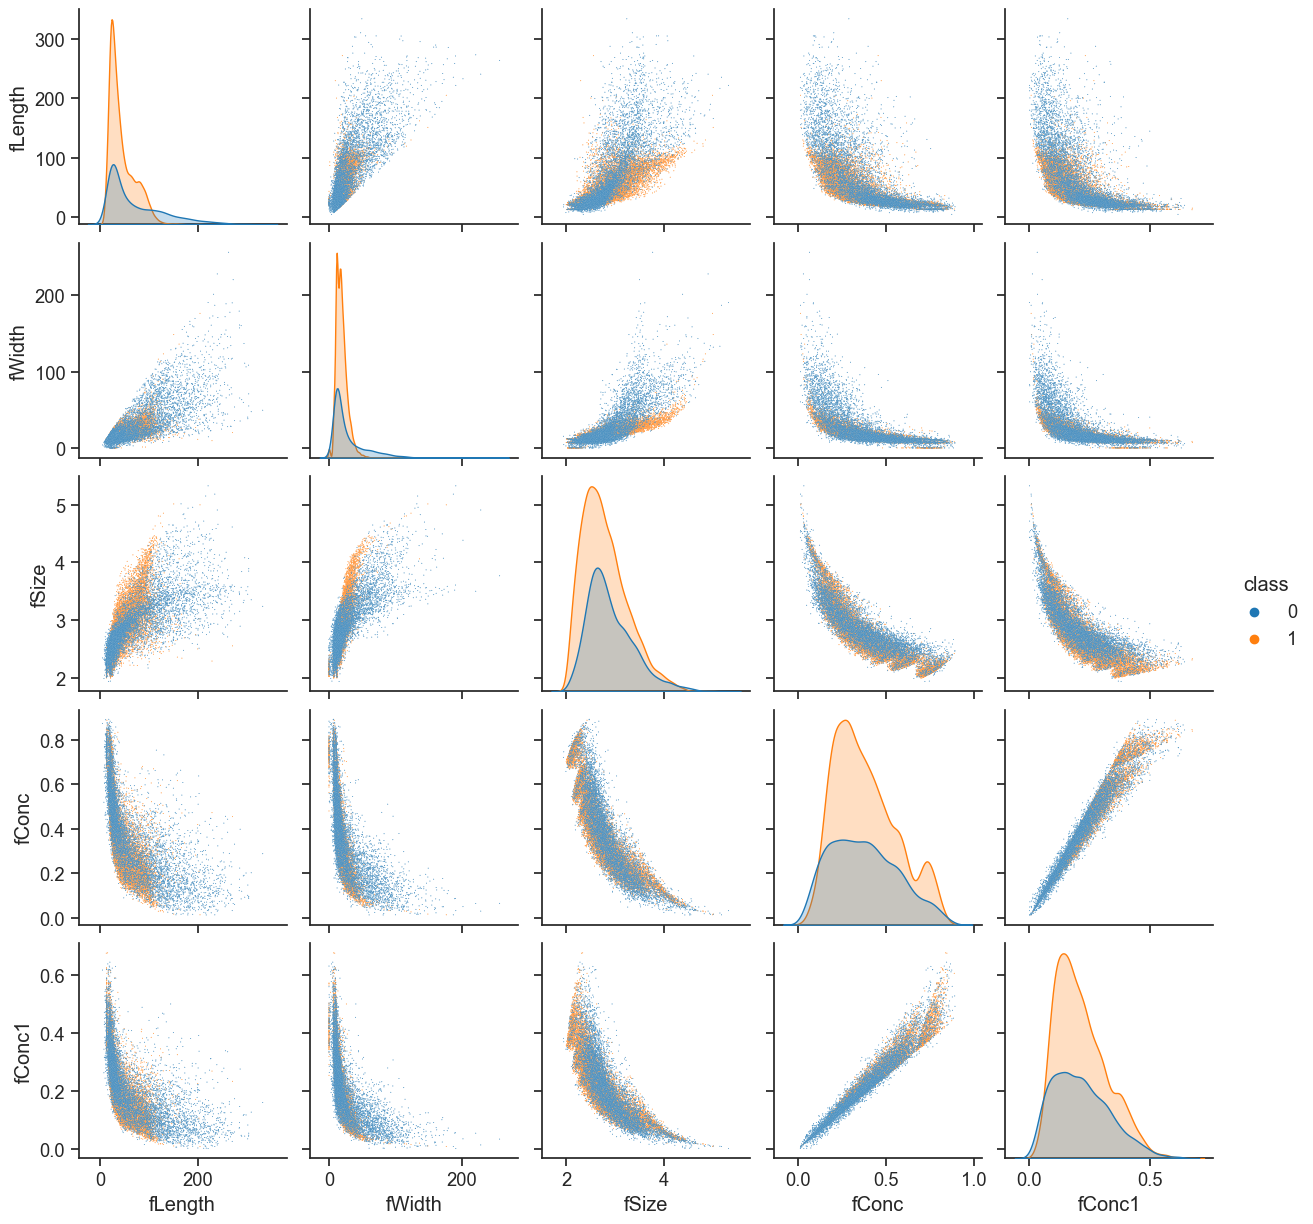

In [9]:
# pairplot with some features to visualize correlations
sns.set(font_scale=1.2)
sns.set_style("ticks")
pairplot = sns.pairplot(data_c, hue='class', plot_kws={'s':0.5}, vars = features[0:5], palette={0:'tab:blue', 1:'tab:orange'})
plt.savefig('pairplot.png', dpi=500, transparent=True, bbox_inches='tight')
plt.show()

From the plot above, we can observe that the most evident correlation is indeed between `fSize` and `fWidth` for signal events. The correlation in the background events is indeed lower and data is more spread.

### 3. Rescaled Width&Length correlation with energy

In order to explore possible ways to distinguish the gamma showers' signals from the background we compare the `fWidth` and `fLength` parameters' distribution applying a cut on `fSize`, that is proportional to the number of photons, so to the primary ray energy. We consider a value of `fSize` bigger than its mean plus its standard deviation and a value lower than its mean minus its standard deviation. 

In [10]:
# rescaling Width and Length 
wmean = data_c['fWidth'].mean()
wstd = data_c['fWidth'].std()

lmean = data_c['fLength'].mean()
lstd = data_c['fLength'].std()

data_rescaled = data_c.copy(deep=True)
data_rescaled['fWidth'] = (data_rescaled['fWidth']-wmean)/wstd
data_rescaled['fLength'] = (data_rescaled['fLength']-lmean)/lstd

# splitting in high number of photons and low
smean = data_rescaled['fSize'].mean()
sstd = data_rescaled['fSize'].std()

data_highs = data_rescaled[data_rescaled['fSize'] >= (smean+sstd)]
data_lows = data_rescaled[data_rescaled['fSize'] <= (smean-sstd)]

/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


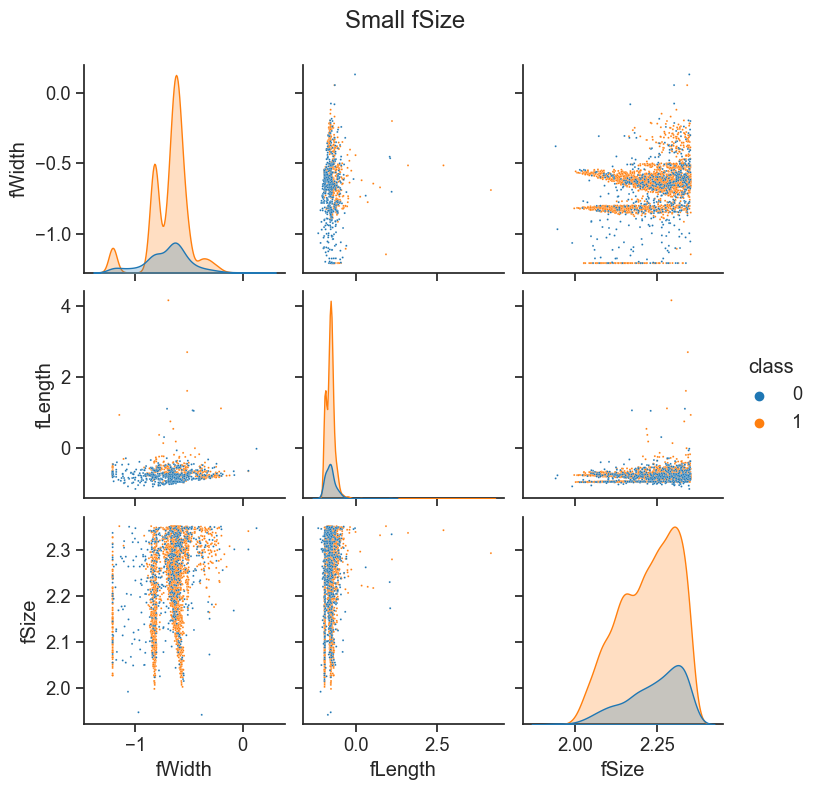

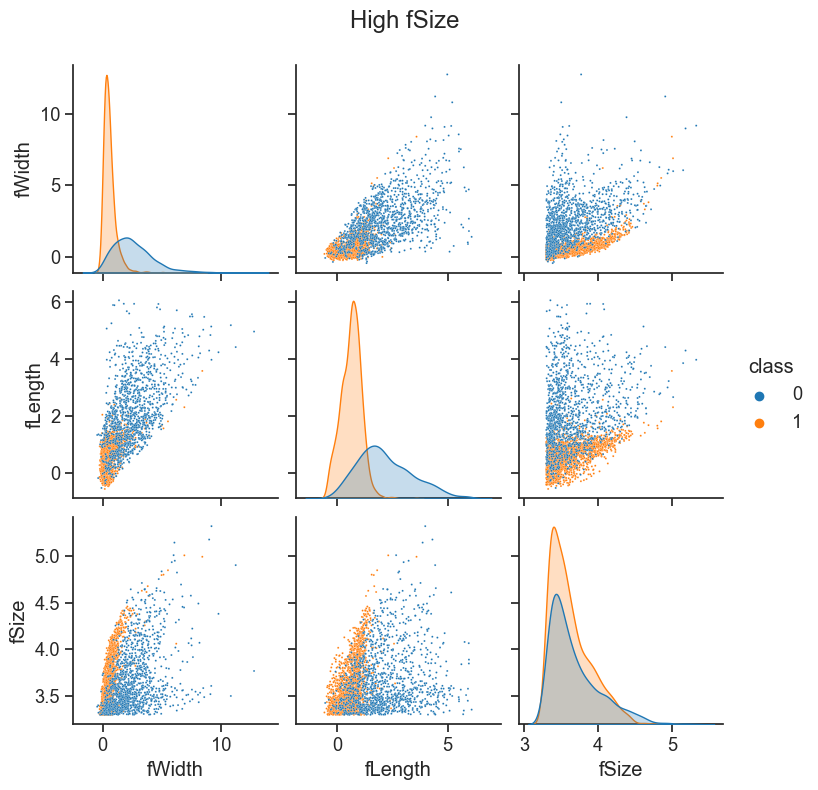

In [11]:
# plot

lowp = sns.pairplot(data_lows, hue='class', plot_kws={'s':2}, vars=['fWidth', 'fLength', 'fSize'], palette={0:'tab:blue', 1:'tab:orange'})
lowp.fig.suptitle('Small fSize', y=1.05)

highp = sns.pairplot(data_highs, hue='class', plot_kws={'s':2}, vars=['fWidth', 'fLength', 'fSize'], palette={0:'tab:blue', 1:'tab:orange'})
highp.fig.suptitle('High fSize', y=1.05)

plt.show()

Comparing the distributions obtained, after standardizing `fWidth` and `fLength`, we can clearly see that for lower `fSize` values, namely low light events, the background samples are more uniformely spread with respect to signal events, moreover there are way more signal events at low energy. On the other hand, for high light events, we can see that signal events are more "clustered" and the respective distributions are less spread with respect to the background ones.

Therefore, applying a cut to obtain only high light events would help us greatly in classifying signals and background events of an experimental dataset.

### 4. PCA

In the following code we will perform Principal Component Analysis (PCA) on magic dataset.

PCA is a statistical technique for reducing the dimensionality of the problem, so the complexity. The main idea is to study whether there are directions in the original feature space (i.e., a linear combination of them) where the data show significant patterns in their distribution. To achieve this, PCA involves the calculation of eigenvectors and eigenvalues from the covariance matrix. These eigenvectors are used to construct a transformation matrix that realigns the dataset into a new coordinate system based on the covariance matrix. In this transformed space, the axes are oriented along the directions of maximum variance. Specifically, the axis corresponding to the eigenvector with the highest eigenvalue represents the direction of maximum variance, while the direction of minimum variance correspondsto the eigenvector with the smallest eigenvalue. It is then possible to reduce the dimensionality of the features by transforming it into the space of principal components and consider only the n most significant ones, so the n features that define the best approximation of the dataset in a lower dimensional space. In order to better understend the dataset we will perform PCA differently for signal and background.

In [12]:
print('PRINCIPAL COMPONENT ANALYSIS for SIGNAL EVENTS')

# preparing dataset for PCA
data_sig_rescaled = (datasig.mean() - datasig) / datasig.std()
data_sig_rescaled = data_sig_rescaled.T

# computing covariance
cov_sig = np.cov(data_sig_rescaled)
l_sig, V_sig = la.eig(cov_sig)

# sorting eigenvalues and eigenvectors by principal components
indices_sorted_sig = np.argsort(np.real(l_sig))[::-1]
l_sorted_sig = np.real(l_sig)[indices_sorted_sig]
V_sorted_sig = V_sig[:, indices_sorted_sig]

# first analysis
print()
perc_sig_cumulative = []
perc_sig_single = []
for i in range(0, len(l_sig)):
    if i == 0:
        p_cumulative = 100 * np.sum(l_sorted_sig[0]) / np.sum(l_sorted_sig)
    else:
        p_cumulative = 100 * np.sum(l_sorted_sig[0:i+1]) / np.sum(l_sorted_sig)
    p_single = 100 * np.sum(l_sorted_sig[i]) / np.sum(l_sorted_sig)
    perc_sig_cumulative.append(p_cumulative)
    perc_sig_single.append(p_single)
    print(f'percentage of information stored in the {i+1} pc: {p_single:.2f}% (cumulative: {p_cumulative:.2f}%)')
    print()

PRINCIPAL COMPONENT ANALYSIS for SIGNAL EVENTS

percentage of information stored in the 1 pc: 50.41% (cumulative: 50.41%)

percentage of information stored in the 2 pc: 11.87% (cumulative: 62.28%)

percentage of information stored in the 3 pc: 10.02% (cumulative: 72.30%)

percentage of information stored in the 4 pc: 8.63% (cumulative: 80.93%)

percentage of information stored in the 5 pc: 7.38% (cumulative: 88.31%)

percentage of information stored in the 6 pc: 5.29% (cumulative: 93.60%)

percentage of information stored in the 7 pc: 2.93% (cumulative: 96.53%)

percentage of information stored in the 8 pc: 2.25% (cumulative: 98.77%)

percentage of information stored in the 9 pc: 1.05% (cumulative: 99.82%)

percentage of information stored in the 10 pc: 0.18% (cumulative: 100.00%)



In [13]:
# mapping the signal dataset with PC features
PCA_dataset_sig = pd.DataFrame(np.dot(V_sig.T, data_sig_rescaled)).T
PCA_dataset_sorted_sig = PCA_dataset_sig.iloc[:, indices_sorted_sig]
PCA_dataset_sorted_sig.columns = [f'PC: {i}' for i in range(1, 11)]

print('\nSignal dataset mapped by P.C. transform:')
PCA_dataset_sorted_sig


Signal dataset mapped by P.C. transform:


,PC: 1,PC: 2,PC: 3,PC: 4,PC: 5,PC: 6,PC: 7,PC: 8,PC: 9,PC: 10
0,1.408198,-0.025290,-0.885679,-1.465734,0.118708,0.004896,0.538901,0.045699,-0.157524,-0.441301
1,-8.170005,-2.490149,-2.430962,6.261337,1.509539,-7.577393,6.403433,-1.013649,4.271203,0.035658
2,2.641611,-0.358448,-0.591096,-0.792379,-0.514495,0.220036,0.854740,-0.430594,-0.159304,-0.204572
3,-2.482953,1.247911,1.495229,-0.985952,0.482751,-1.247225,0.321294,0.218133,0.244444,-0.003138
4,-1.535497,-0.908474,0.585139,-0.993558,-0.226842,-0.242264,-0.455343,0.151934,0.269470,-0.072728
...,...,...,...,...,...,...,...,...,...,...
12326,2.612071,0.896166,0.794237,-0.974024,0.372073,-0.047435,0.667051,0.531120,-0.140600,0.361254
12327,0.068467,0.437516,-0.657439,0.205893,-1.242627,-0.449964,0.317647,0.504826,-0.111550,-0.144009
12328,1.989974,-0.497194,0.508345,-0.437988,-0.045510,0.611507,0.059556,-0.060813,0.220679,0.064600
12329,-0.622114,-1.458725,0.772080,-0.429652,-1.907145,-1.754328,-0.322473,-0.931343,-0.185253,-0.031244


In [14]:
print('PRINCIPAL COMPONENT ANALYSIS for BACKGROUND EVENTS')

# preparing dataset for PCA
data_bkg_rescaled = (databkg.mean() - databkg) / databkg.std()
data_bkg_rescaled = data_bkg_rescaled.T

# computing covariance
cov_bkg = np.cov(data_bkg_rescaled)
l_bkg, V_bkg = la.eig(cov_bkg)

# sorting eigenvalues and eigenvectors by principal components
indices_sorted_bkg = np.argsort(np.real(l_bkg))[::-1]
l_sorted_bkg = np.real(l_bkg)[indices_sorted_bkg]
V_sorted_bkg = V_bkg[:, indices_sorted_bkg]

# first analysis
print()
perc_bkg_cumulative = []
perc_bkg_single = []
for i in range(0, len(l_sig)):
    if i == 0:
        p_cumulative = 100 * np.sum(l_sorted_bkg[0]) / np.sum(l_sorted_bkg)
    else:
        p_cumulative = 100 * np.sum(l_sorted_bkg[0:i+1]) / np.sum(l_sorted_bkg)
    p_single = 100 * np.sum(l_sorted_bkg[i]) / np.sum(l_sorted_bkg)
    perc_bkg_cumulative.append(p_cumulative)
    perc_bkg_single.append(p_single)
    print(f'percentage of information stored in the {i+1} pc: {p_single:.2f}% (cumulative: {p_cumulative:.2f}%)')
    print()

PRINCIPAL COMPONENT ANALYSIS for BACKGROUND EVENTS

percentage of information stored in the 1 pc: 44.24% (cumulative: 44.24%)

percentage of information stored in the 2 pc: 12.08% (cumulative: 56.32%)

percentage of information stored in the 3 pc: 10.38% (cumulative: 66.70%)

percentage of information stored in the 4 pc: 9.94% (cumulative: 76.64%)

percentage of information stored in the 5 pc: 8.04% (cumulative: 84.67%)

percentage of information stored in the 6 pc: 6.99% (cumulative: 91.67%)

percentage of information stored in the 7 pc: 4.37% (cumulative: 96.04%)

percentage of information stored in the 8 pc: 2.22% (cumulative: 98.26%)

percentage of information stored in the 9 pc: 1.50% (cumulative: 99.76%)

percentage of information stored in the 10 pc: 0.24% (cumulative: 100.00%)



In [15]:
# mapping the background dataset with PC features
PCA_dataset_bkg = pd.DataFrame(np.dot(V_bkg.T, data_bkg_rescaled)).T
PCA_dataset_sorted_bkg = PCA_dataset_bkg.iloc[:, indices_sorted_bkg]
PCA_dataset_sorted_bkg.columns = [f'PC: {i}' for i in range(1, 11)]

print('\nBackground dataset mapped by P.C. transform:')
PCA_dataset_sorted_bkg


Background dataset mapped by P.C. transform:


,PC: 1,PC: 2,PC: 3,PC: 4,PC: 5,PC: 6,PC: 7,PC: 8,PC: 9,PC: 10
0,1.081815,-1.390628,1.433285,-1.188184,-0.054034,-0.081178,0.090184,-0.202012,-0.153733,-0.109372
1,1.765870,-1.264881,-0.452745,0.836379,1.279351,0.728186,-1.014617,-0.457150,0.278220,-0.156463
2,1.002987,0.168557,1.650507,-0.405061,1.198677,0.374780,-0.339178,-0.490341,0.133168,0.204703
3,-0.661968,1.020834,-1.147386,1.260250,-0.616097,-0.202869,0.201592,-0.385424,0.315469,-0.496258
4,-0.535388,0.181471,0.452065,-0.423179,-0.639122,0.492311,-0.510318,0.238314,0.154695,0.241135
...,...,...,...,...,...,...,...,...,...,...
6683,-2.341099,0.616816,0.899608,-0.529944,-1.155450,-0.122355,0.673725,0.389632,0.407223,-0.234917
6684,-1.855326,-0.330549,-0.979542,0.502140,1.453699,-0.252921,-0.360780,-0.435377,-0.461469,0.126549
6685,1.914954,-0.973399,1.099702,-0.196153,0.224853,-0.023972,-0.427303,0.468652,-0.027221,0.087053
6686,3.870064,-0.224963,0.037371,2.188799,2.131373,-1.729546,-0.388508,0.553096,0.342839,-0.075766


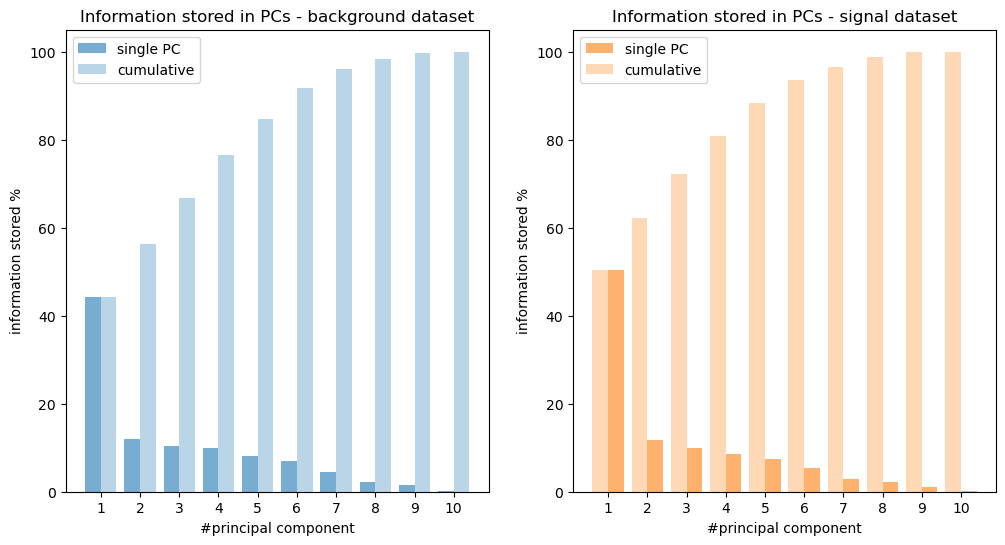

In [211]:
# histograms to visualize decomposition
sns.reset_defaults()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
width=0.4

pcs = np.arange(1,11)

ax[0].bar(x = pcs - width/2, height = perc_bkg_single, width=width, label='single PC', alpha=0.6, color='C0')
ax[0].bar(x = pcs + width/2, height = perc_bkg_cumulative, width=width, label='cumulative', alpha=0.3, color='C0')
ax[0].legend()
ax[0].set_ylabel('information stored %')
ax[0].set_xlabel('#principal component')
ax[0].set_title('Information stored in PCs - background dataset')
ax[0].set_xticks(pcs)

ax[1].bar(x = pcs + width/2, height = perc_sig_single, width=width, label='single PC', alpha=0.6, color='C1')
ax[1].bar(x = pcs - width/2, height = perc_sig_cumulative, width=width, label='cumulative', alpha=0.3, color='C1')
ax[1].legend()
ax[1].set_ylabel('information stored %')
ax[1].set_xlabel('#principal component')
ax[1].set_title('Information stored in PCs - signal dataset')
ax[1].set_xticks(pcs)

plt.show()

The analysis conducted showed no particular differences between the signal and background data, as visible from the evolution of the comulative probability. The first component succeeds in describing for both classes quite half of the dataset, while the others complete the remaining information, generally showing no marginality except for the last two principal components.

Since the principal components are linear combination of the original futures, it is not possible to define which feature of the dataset is the most influential. It is therefore decided to perform the next analyses with the full original dataset.

### 5. Classification between signal and background events

The dataset, divided into two classes, outlines a generic binary classification problem. The approach presented is based on the study and optimization of four different machine learning models and in-depth analysis of the model that shows the best performance. The classification models introduced here and then further investigated are: K-Nearest Neighbor (K-NN), Support Vector Machine (SVM) with kernels, Feedforward Neural Network and Random Forest.

The metrics selected to evaluate the performance of each classifier obtained include ROC curve, area underneath ROC (AUC) and quality factor $Q=\frac{\epsilon_{\gamma}}{\sqrt{\epsilon_h}}$, where $\epsilon_{\gamma}$ represent the percentage of correctly classified signals and $\epsilon_h$ the percentage of hadrons classified as signal. The challenge, referred to a real physics case, is the ability to discriminate gamma rays from background noise while minimizing false positives, i.e. background events classified as gamma rays.

We want to highlight that it is therefore not possible to adopt accuracy as the main metric for model performance evaluation because it gives equal importance to signal and background. Consequently, our primary goal is to maximize the quality factor and the area under the ROC curve, not paying too much attention at the number of signal events classified as background, in order to obtain better quality data.

The best models for each type of classifier are obtained through a grid search, trained and evaluated on 70% of the dataset. Once each best classifier is identified, it will then be tested on the remaining 30% to fine-tune the hyperparameters and evaluate its overall quality metrics.

In [18]:
# preparing datasets

X = data_c.copy(deep=True)
X = data_c.drop(columns='class')

# calculating mean and std to normalize dataset before analysis
mean_all = X.mean(axis=0)
std_all = X.std(axis=0)

np.random.seed(13012023)

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3)
X_train, X_val, Y_train, Y_val = train_test_split( X_train, Y_train, test_size=0.15)
X_test1, X_test2, Y_test1, Y_test2 = train_test_split(X_test, Y_test, test_size=0.5)

X_train_no_alpha = (X_train-mean_all)/std_all
X_train_no_alpha = X_train_no_alpha.drop(columns='fAlpha')
_, freq_train = np.unique(Y_train, return_counts=True)
print('Training set size:', Y_train.size)
print(f'Frequencies in training set: \n - bkg {freq_train[0]} ({100*freq_train[0]/Y_train.size:.1f}%) \n - signal {freq_train[1]} ({100*freq_train[1]/Y_train.size:.1f}%)')

X_val_no_alpha = (X_val-mean_all)/std_all
X_val_no_alpha = X_val_no_alpha.drop(columns='fAlpha')
_, freq_val = np.unique(Y_val, return_counts=True)
print('\nValidation set tize:', Y_val.size)
print(f'Frequencies in validation set: \n - bkg {freq_val[0]} ({100*freq_val[0]/Y_val.size:.1f}%) \n - signal {freq_val[1]} ({100*freq_val[1]/Y_val.size:.1f}%)')

X_test1_no_alpha = (X_test1-mean_all)/std_all
X_test1_no_alpha = X_test1_no_alpha.drop(columns='fAlpha')
_, freq_test1 = np.unique(Y_test1, return_counts=True)
print('\nFirst test set size:', Y_test1.size)
print(f'Frequencies in training set: \n - bkg {freq_test1[0]} ({100*freq_test1[0]/Y_test1.size:.1f}%) \n - signal {freq_test1[1]} ({100*freq_test1[1]/Y_test1.size:.1f}%)')

X_test2_no_alpha = (X_test2-mean_all)/std_all
X_test2_no_alpha = X_test2_no_alpha.drop(columns='fAlpha')
_, freq_test2 = np.unique(Y_test2, return_counts=True)
print('\nFirst test set size:', Y_test2.size)
print(f'Frequencies in training set: \n - bkg {freq_test2[0]} ({100*freq_test2[0]/Y_test2.size:.1f}%) \n - signal {freq_test2[1]} ({100*freq_test2[1]/Y_test2.size:.1f}%)')

Training set size: 11316
Frequencies in training set: 
 - bkg 3986 (35.2%) 
 - signal 7330 (64.8%)

Validation set tize: 1997
Frequencies in validation set: 
 - bkg 707 (35.4%) 
 - signal 1290 (64.6%)

First test set size: 2853
Frequencies in training set: 
 - bkg 1007 (35.3%) 
 - signal 1846 (64.7%)

First test set size: 2853
Frequencies in training set: 
 - bkg 988 (34.6%) 
 - signal 1865 (65.4%)


### 5.1 K-Nearest Neighbors

The first method used to build a classifier able to accurately distinguish the gamma showers' signals from the hadron ones was the K-nearest neighbors algorithm, a rather simple machine learning method where the gammaness of a tested sample is assigned through a majority vote on the k closest neighbours to such sample according to a specified metric. In the literature [1] such method is implemented through the metric: $\Delta=(x-x_r)^TC_r^{-1}(x-x_r)$, where $x_r$ is the sample to be tested, $x$ are the training samples we use to validate it and $C_r$ is the covariance matrix of the whole dataset. However after noticing the prohibitive computational times linked to its linear algebra computations we chose to use a metric which is by default implemented into the relative sklearn method (the "minkoswki" one) after properly normalizing the samples by their means and std using the StandardScaler built in method. <br>
To properly get the number of K neighbours considered in each voting that maximizes the area under the ROC curve (AUC) for our particular dataset we perform a search over K from 1 to 100 with a step of 5, estimating the AUC precisely for each K performing k fold cross validation (with k=8) and getting the AUC as the mean over these splits.

In [ ]:
# first merging train and validation sets to enable cross validation and not lose data
X_train_cv = pd.concat([X_train_no_alpha, X_val_no_alpha])
Y_train_cv = pd.concat([Y_train, Y_val])

In [161]:
# grid search for best k maximizing ROC auc with cross validation
kappas = [k for k in range(5,101,5)]
kappas.insert(0,1)

best_knn_roc_auc = 0

# looping over kappas
for k in kappas:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    roc_cross_val = cross_val_score(knn, X_train_cv, Y_train_cv, cv=8, scoring='roc_auc').mean()
    
    if roc_cross_val > best_knn_roc_auc:
        best_knn_roc_auc = roc_cross_val
        best_knn = [k, best_knn_roc_auc]

print(f'Best number of neigbours that maximize ROC auc, corresponding ROC auc: {best_knn[0]}\t{best_knn[1]:.3f}')

Best number of neigbours that maximize ROC auc, corresponding ROC auc: 35	0.829


In [162]:
# best kNN based on maximizing ROC auc
kNNauc = KNeighborsClassifier(n_neighbors=best_knn[0], weights='distance', n_jobs=-1)
kNNauc.fit(X_train_no_alpha, Y_train)
kNNauc_pred = kNNauc.predict(X_test1_no_alpha)
kNNauc_prob = kNNauc.predict_proba(X_test1_no_alpha)

kNNauc_acc = skm.accuracy_score(Y_test1, kNNauc_pred)
kNNauc_auc = skm.roc_auc_score(Y_test1, kNNauc_prob[:,1])
print(f'Best kNN model (based on ROC auc) ROC auc and accuracy: {kNNauc_auc:.3f}\t{kNNauc_acc:.3f}')

Best kNN model (based on ROC auc) ROC auc and accuracy: 0.841	0.783


kNN Q factor: 1.30


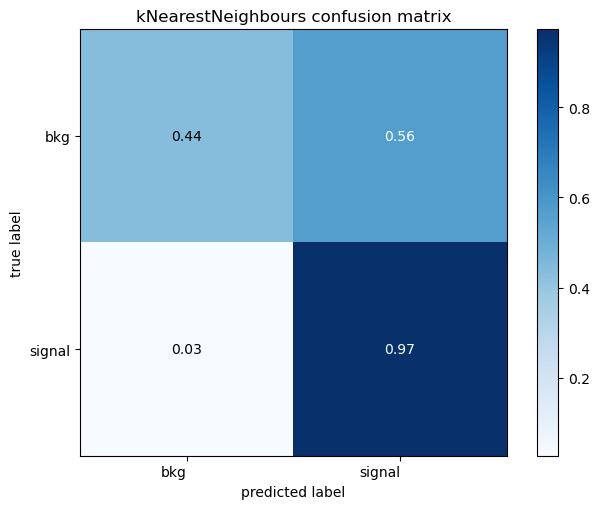

In [222]:
# confusion matrix
labels, freqs = np.unique(Y_test1, return_counts=True) 
cm_kNN = skm.confusion_matrix(Y_test1, kNNauc_pred)
cm_kNN = cm_kNN/freqs[:,None]
betskNN_Q = cm_kNN[1][1]/np.sqrt(cm_kNN[0][1])
print(f'kNN Q factor: {betskNN_Q:.2f}')

fig = plt.figure()

imkNN = plt.imshow(cm_kNN, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_kNN.max() / 2.
for i in range(cm_kNN.shape[0]):
    for j in range(cm_kNN.shape[1]):
        plt.text(j, i, format(cm_kNN[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_kNN[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imkNN, location = 'right') 

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.title('kNearestNeighbours confusion matrix')
plt.show()

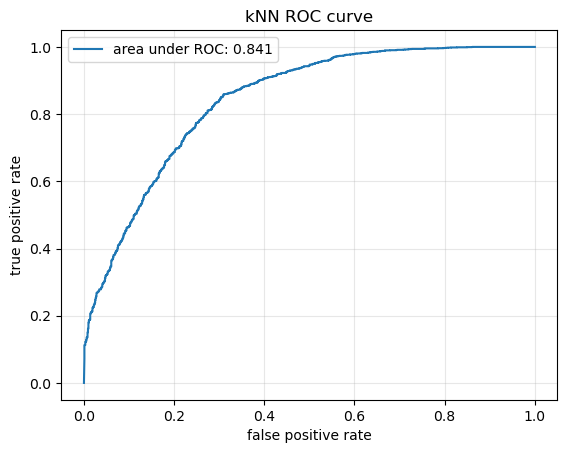

In [212]:
# plot ROC
fpr_kNN, tpr_kNN, _ = skm.roc_curve(Y_test1, kNNauc_prob[:,1])

fig, ax = plt.subplots()
ax.grid(alpha=0.3)

ax.plot(fpr_kNN, tpr_kNN, label=f'area under ROC: {kNNauc_auc:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('kNN ROC curve')

plt.show()

### 5.2 SVM

Support Vector Machines (SVMs) are machine learning models that are able to identifying the optimal linear separator to maximize the margin, which is the distance between the separator and the examples from two distinct classes. In many real cases, including this one, the data are not linearly separable, making a simple linear separator not effective. To make the data linearly separable, a soft SVM with a strategy known as the "kernel trick" is employed. This involves projecting the data into a higher-dimensional feature space using a kernel function. In this higher-dimensional space, it becomes feasible to perform SVM on more distinctly separated data, yielding qualitatively superior results. The kernel functions explored here include three polynomial mappings and one Gaussian mapping, the quality of the model performance is evalued with the ROC.

In [192]:
# define SVM model, then train and test
# polynomial kernel
C_par_poly = 15
gamma_par_poly = 0.1
print('\nC parameter for polynomial kernels:', C_par_poly)
print('gamma parameter for polynomial kernels:', gamma_par_poly)
# degree 2
poly2_svm = SVC(kernel='poly', degree=2, C=C_par_poly, gamma=gamma_par_poly, probability = True)
roc_auc_poly2 = cross_val_score(poly2_svm, X_train_cv, Y_train_cv, scoring='roc_auc')
print(f'\nPolynomial kernel with degree=2 area under ROC: {roc_auc_poly2.mean():.3f}')


C parameter for polynomial kernels: 15
gamma parameter for polynomial kernels: 0.1
Polynomial kernel with degree=2 area under ROC: 0.830


In [193]:
# degree 3
poly3_svm = SVC(kernel='poly', degree=3, C=C_par_poly, gamma=gamma_par_poly, probability = True)
roc_auc_poly3 = cross_val_score(poly3_svm, X_train_cv, Y_train_cv, scoring='roc_auc')
print(f'Polynomial kernel with degree=3 area under ROC: {roc_auc_poly3.mean():.3f}')

Polynomial kernel with degree=3 area under ROC: 0.796


In [194]:
# degree 4
poly4_svm = SVC(kernel='poly', degree=4, C=C_par_poly, gamma=gamma_par_poly, probability = True)
roc_auc_poly4 = cross_val_score(poly4_svm, X_train_cv, Y_train_cv, scoring='roc_auc')
print(f'Polynomial kernel with degree=4 area under ROC: {roc_auc_poly4.mean():.3f}')

Polynomial kernel with degree=4 area under ROC: 0.818


In [195]:
# RBF kernel
rbf_svm = SVC(kernel='rbf', C=10, gamma=1, probability = True)
roc_auc_rbf = cross_val_score(rbf_svm, X_train_cv, Y_train_cv, scoring='roc_auc')
print(f'RBF kernel area under ROC: {roc_auc_rbf.mean():.3f}')

RBF kernel area under ROC: 0.843


Best kernel is RBF, so we perform a grid search for the best gamma parameter.

In [158]:
# parameter and models
gamma_values = [0.01, 0.1, 0.25, 0.5, 1, 5, 10, 15]
RBFmodels = [SVC(kernel='rbf', C=5, gamma=i, probability = True) for i in gamma_values]

# train every model
for mod in RBFmodels:
    mod.fit(X_train_no_alpha, Y_train)

# make predictions on test set with every model
RBFtrain_predictions = [mod.predict(X_train_no_alpha) for mod in RBFmodels]
RBFtest_predictions = [mod.predict(X_val_no_alpha) for mod in RBFmodels]

# calculate train and test accuracy
RBFtrain_acc_list = [ skm.accuracy_score(Y_train, pred) for pred in RBFtrain_predictions ]
RBFtest_acc_list = [ skm.accuracy_score(Y_val, pred) for pred in RBFtest_predictions ]

# calculate area under ROC
RBF_prob_pred = [mod.predict_proba(X_val_no_alpha) for mod in RBFmodels]
RBF_areaunderROC = [skm.roc_auc_score(Y_val, prob[:,1]) for prob in RBF_prob_pred]

best_idx = np.argmax(RBFtest_acc_list)
print(f'Highest test accuracy: {np.max(RBFtest_acc_list):.3f} \t Corresponding gamma parameter: {gamma_values[best_idx]}')

best_roc = np.argmax(RBF_areaunderROC)
print(f'\nHighest area under ROC: {np.max(RBF_areaunderROC):.3f} \t Corresponding gamma parameter: {gamma_values[best_roc]}')

Highest test accuracy: 0.827 	 Corresponding gamma parameter: 0.25

Highest area under ROC: 0.866 	 Corresponding gamma parameter: 0.25


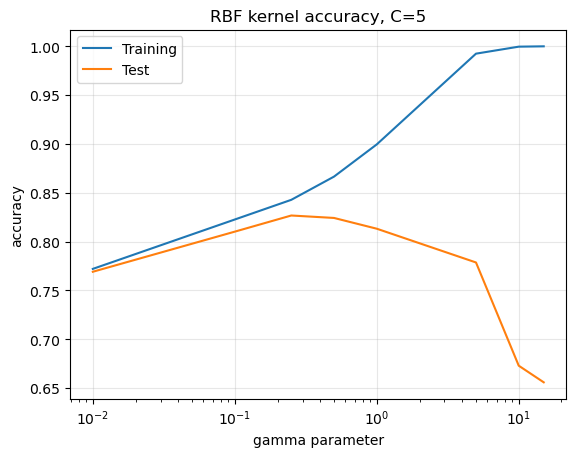

In [56]:
# plot
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(gamma_values, RBFtrain_acc_list, label='Training')
ax.plot(gamma_values, RBFtest_acc_list, label='Test')
ax.set_title('SVM with RBF kernel accuracy, C=5')
ax.set_xlabel('gamma parameter')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.legend()

plt.show()

RBF kernel accuracy: 0.821

RBF kernel Q factor: 1.46


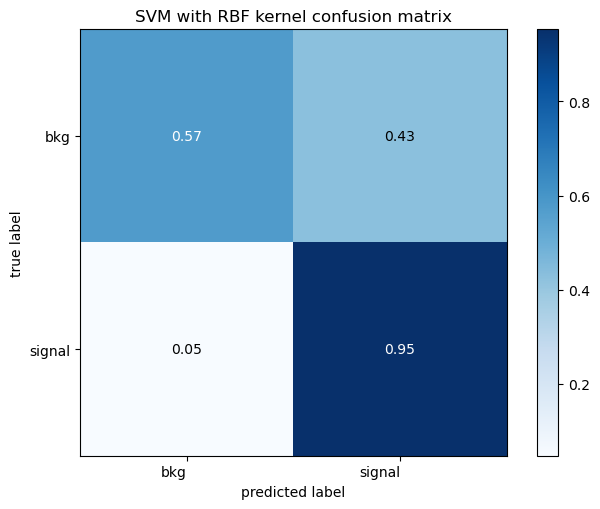

In [223]:
# confusion matrix and ROC for best RBF classifier based on ROC auc
bestRBF = SVC(kernel='rbf', C=5, gamma=gamma_values[best_roc], probability=True)
bestRBF.fit(X_train_no_alpha, Y_train)
bestRBF_pred = bestRBF.predict(X_test2_no_alpha)
bestRBF_accuracy = skm.accuracy_score(Y_test2, bestRBF_pred)
bestRBF_prob = bestRBF.predict_proba(X_test2_no_alpha)
print(f'RBF kernel accuracy: {bestRBF_accuracy:.3f}')
auc_RBF = skm.roc_auc_score(Y_test2, bestRBF_prob[:,1])

labels, freqs = np.unique(Y_test2, return_counts=True) 
cm_RBF = skm.confusion_matrix(Y_test2, bestRBF_pred)
cm_RBF = cm_RBF/freqs[:,None]
betsRBF_Q = cm_RBF[1][1]/np.sqrt(cm_RBF[0][1])
print(f'\nRBF kernel Q factor: {betsRBF_Q:.2f}')

fig = plt.figure()

imRBF = plt.imshow(cm_RBF, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_RBF.max() / 2.
for i in range(cm_RBF.shape[0]):
    for j in range(cm_RBF.shape[1]):
        plt.text(j, i, format(cm_RBF[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_RBF[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imRBF, location = 'right') 

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('SVM with RBF kernel confusion matrix')
plt.show()

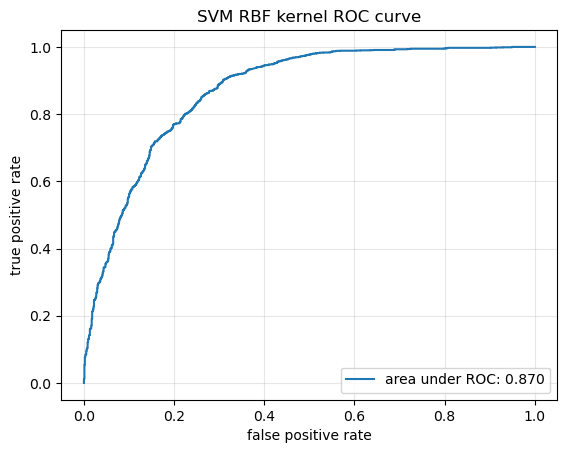

In [213]:
# plot ROC
fpr_RBF, tpr_RBF, t = skm.roc_curve(Y_test2, bestRBF_prob[:,1])

fig, ax = plt.subplots()
ax.grid(alpha=0.3)

ax.plot(fpr_RBF, tpr_RBF, label=f'area under ROC: {auc_RBF:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('SVM RBF kernel ROC curve')

plt.show()

The results obtained from maximizing the ROC curve identify the Gaussian kernel as the best among the four studied kernel. 

### 5.3 Neural Network

Neural networks are sophisticated models used for classification. This process involves feeding each feature of an example into computational units, also known as neurons, where they are processed and computed by an activation function. The output of this function then becomes input for neurons of the next layer. The signal continues to propagate until it reaches the output neurons, dedicated to each class of the classification problem.The class is determinated by the output neuron with the highest activation function computed. 

In this study, we employ a feedforward fully connected Neural Network, where every neuron in one layer is connected to every neurons in the next layer. The Rectified Linear Unit (ReLU) function is chosen as the activation function, and the optimal network architecture, as well as the initial learning rate, was determined through a grid search aimed at maximizing the area under the ROC curve. Here, "architecture" refers to the configuration of layers and neurons within the network.
With NN there is a heigh risk of overfitting, especially without the application of regularization techniques. To mitigate this, we incorporate $l_2$ regularization into our model.

In [32]:
def grid_search_crossval(model, par, Xtrain, Ytrain):
    rocauc = 0
    for lr in par['learning_rate_init']:
        for hidden_l in par['hidden_layer_sizes']:
            model.set_params(hidden_layer_sizes=hidden_l, learning_rate_init = lr)
            roc_auc = cross_val_score(model, Xtrain, Ytrain, scoring='roc_auc').mean()
            print('architecture:', lr, hidden_l)
            
            if roc_auc > rocauc:
                best_auc = [hidden_l, lr ]
                rocauc = roc_auc

    return best_auc, rocauc 

In [33]:
# grid search on area under roc for best architecture
parameters = {'hidden_layer_sizes': [(32,), (64,), (32,16), (64,32), (64,32,16)], 
              'learning_rate_init': [0.2,0.02,0.002]}

NN_model = MLPClassifier(activation='relu', learning_rate = 'adaptive', alpha=0.05, max_iter=600)

print('NN grid search with cross validation \n------------------------')
best_arch_auc, nn_auc = grid_search_crossval(NN_model, parameters, X_train_cv, Y_train_cv)
print('-----------------------')

NN grid search with cross validation 
------------------------
architecture: 0.2 (32,)
architecture: 0.2 (64,)
architecture: 0.2 (32, 16)
architecture: 0.2 (64, 32)
architecture: 0.2 (64, 32, 16)
architecture: 0.02 (32,)
architecture: 0.02 (64,)
architecture: 0.02 (32, 16)
architecture: 0.02 (64, 32)
architecture: 0.02 (64, 32, 16)
architecture: 0.002 (32,)
architecture: 0.002 (64,)
architecture: 0.002 (32, 16)
architecture: 0.002 (64, 32)
architecture: 0.002 (64, 32, 16)
-----------------------


In [34]:
print('Best NN architecture and learning rate based on maximizing area under ROC:', best_arch_auc)
print(f'Corresponding area under ROC: {nn_auc:.3f}')

Best NN architecture and learning rate based on maximizing area under ROC: [(32, 16), 0.002]
Corresponding area under ROC: 0.867


In [35]:
# best NN model based on maximizing auc
bestNNmodel = MLPClassifier(activation='relu', hidden_layer_sizes = best_arch_auc[0], learning_rate_init=best_arch_auc[1], max_iter=600, learning_rate = 'adaptive', alpha=0.05)
bestNNmodel.fit(X_train_no_alpha, Y_train)
bestNNmodel_pred = bestNNmodel.predict(X_test1_no_alpha)
bestNNmodel_prob = bestNNmodel.predict_proba(X_test1_no_alpha)

# accuracy and roc 
bestNNmodel_acc = skm.accuracy_score(Y_test1, bestNNmodel_pred)
print(f'Best NN model accuracy: {bestNNmodel_acc:.3f}')
bestNNmodel_auc = skm.roc_auc_score(Y_test1, bestNNmodel_prob[:,1])
print(f'Best NN model area under ROC: {bestNNmodel_auc:.3f}')

Best NN model accuracy: 0.824
Best NN model area under ROC: 0.877


Neural network Q factor: 1.56


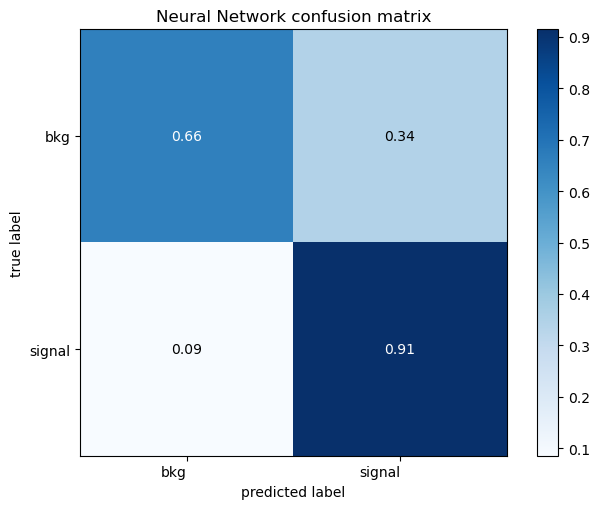

In [226]:
# confusion matrix
labels, freqs = np.unique(Y_test1, return_counts=True) 
cm_NN = skm.confusion_matrix(Y_test1, bestNNmodel_pred)
cm_NN = cm_NN/freqs[:,None]
betsNN_Q = cm_NN[1][1]/np.sqrt(cm_NN[0][1])
print(f'Neural network Q factor: {betsNN_Q:.2f}')

fig = plt.figure()

imNN = plt.imshow(cm_NN, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_NN.max() / 2.
for i in range(cm_NN.shape[0]):
    for j in range(cm_NN.shape[1]):
        plt.text(j, i, format(cm_NN[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_NN[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imNN, location = 'right') 
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Neural Network confusion matrix')
plt.show()

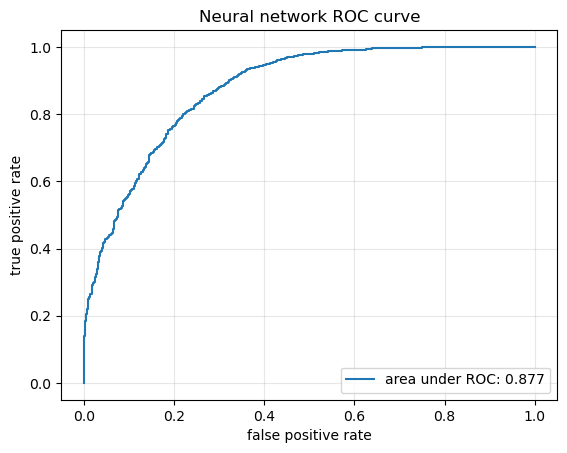

In [214]:
# plot ROC
fpr_NN, tpr_NN, _ = skm.roc_curve(Y_test1, bestNNmodel_prob[:,1])

fig, ax = plt.subplots()
ax.grid(alpha=0.3)

ax.plot(fpr_NN, tpr_NN, label=f'area under ROC: {bestNNmodel_auc:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('Neural network ROC curve')

plt.show()

The results shows good performance obtained by a simple NN with few neurons, the best-auc performing network is made by only two layers, a likely outcome due to the dataset being composed of relatively few features.

The neural network seems to be a potentially good model for studying this phenomenon, analysis justified by the area under the ROC curve and the value of the quality factor. NN models offers potential for further quality improovement through exploration of different architectural designs, but the theoretical inexplicability, does not allow us to study how the prediction occurs based on physics.

### 5.4 Random Forest

Another classifier we used for our classification task is the Random Forest. A random forest is composed by various decision trees: predictors that assign labels to data according to decisions based on some features of the data; in our case each leaf is labelled as signal or background.
To make the results less dependent on the data and consequently more accurate with respect to the results obtained with only one single tree the idea is to construct a collection of trees (forest) and use a majority voting over the trees to decide the predicted label.

To best construct our classifier we first performed a grid search on the following parameters of `sklearn.ensemble.RandomForestClassifier`:
* `n_estimators`: the number of trees that compose the forest
* `max_depth`: the maximum number of layers of a tree
The `max_feature` parameter correspond to the maximum number of features, taken randomly with replacement, that each tree uses to split its leafs. Note also that the implementation used perform pruning procedure by default.

The performance of the classifier on our data is then evaluated for maximizing the area under the ROC curve.

In [26]:
# grid search: find the best model that maximize the area under the roc curve 
AUC = []

trees = np.arange(20,100,5)
depth = np.arange(10,32,2) 

for t in trees:
    for d in depth:
        # defining model
        model = RandomForestClassifier(n_jobs=-1, n_estimators=t, max_depth=d, max_features=4)
        # training on training set
        model.fit(X_train_no_alpha, Y_train)
        # validation on validation set
        prob = model.predict_proba(X_val_no_alpha)
        roc_auc = skm.roc_auc_score(Y_val, prob[:,1])
        pred = model.predict(X_val_no_alpha)
        acc = skm.accuracy_score(Y_val, pred)
        
        # save depth, #trees, area under ROC, accuracy
        AUC.append([d,t,roc_auc, acc])

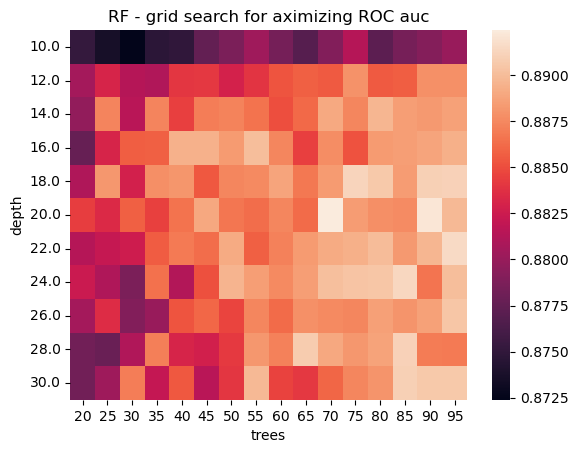

In [218]:
# visualizing grid search for maximizing auc
AUC = pd.DataFrame(np.array(AUC), columns=['depth', 'trees', 'auc', 'acc'])
grid_auc = AUC.pivot(index="depth", columns="trees", values="auc")
sns.heatmap(grid_auc)
plt.title('RF - grid search for aximizing ROC auc')
xticks = [i+0.5 for i in range(16)]
xlab = [i+5 for i in range(15,95) if i%5 == 0]
plt.xticks(ticks=xticks, labels=xlab, rotation=0)
yticks = [i+0.5 for i in range(11)]
plt.yticks(ticks=yticks, rotation=0)
plt.show()

In [219]:
# finding the best parameter model based on ROC  
max_index_auc = np.argmax(AUC['auc'])
best_auc = round(AUC['auc'].iloc[max_index_auc],3)
best_trees_auc = int(AUC['trees'].iloc[max_index_auc])
best_depth_auc = int(AUC['depth'].iloc[max_index_auc])
corr_acc = round(AUC['acc'].iloc[max_index_auc],3)

print('Best model that maximize area under ROC:')
print(' - depth',best_depth_auc)
print(' - trees', best_trees_auc)
print(' - auc', best_auc)
print(' - corresponding accuracy', corr_acc)

Best model that maximize area under ROC:
 - depth 20
 - trees 70
 - auc 0.892
 - corresponding accuracy 0.837


Once found the best values for the number of trees in the forest and for the maximum depth of a tree we retrain our best model and test it on the test set.
To evaluate the quality of its classification we compute the value of Q, show the confusion matrix and plot the ROC curve computed.

In [217]:
# best model based on maximizing auc
best_model_auc = RandomForestClassifier(n_estimators=best_trees_auc, max_depth=best_depth_auc) 
best_model_auc.fit(X_train_no_alpha, Y_train) 
best_model_pred_auc = best_model_auc.predict(X_test1_no_alpha)
best_model_prob_auc = best_model_auc.predict_proba(X_test1_no_alpha)

# accuracy and roc 
best_model_auc_acc = skm.accuracy_score(Y_test1, best_model_pred_auc)
print(f'Best random forest model accuracy: {best_model_auc_acc:.3f}')
best_model_auc_auc = skm.roc_auc_score(Y_test1, best_model_prob_auc[:,1])
print(f'Best random forest model area under ROC: {best_model_auc_auc:.3f}')

Best random forest model accuracy: 0.836
Best random forest model area under ROC: 0.890


Random Forest Q factor: 1.59


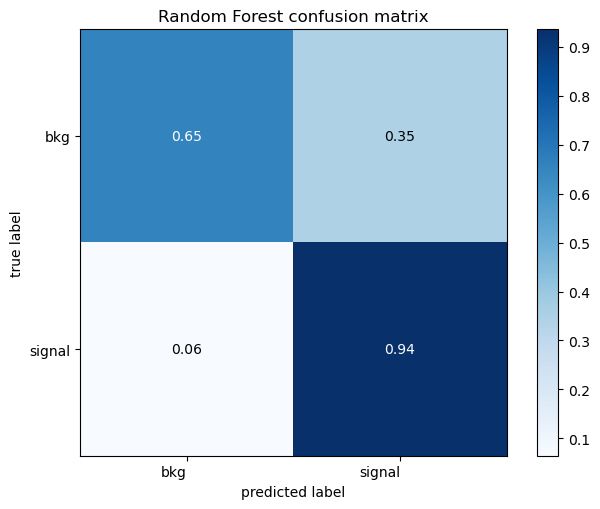

In [225]:
# confusion matrix from best model based on auc
labels, freqs = np.unique(Y_test1, return_counts=True) 
cm_RF = skm.confusion_matrix(Y_test1, best_model_pred_auc)
cm_RF = cm_RF/freqs[:,None]
bestRF_Q = cm_RF[1][1]/np.sqrt(cm_RF[0][1])
print(f'Random Forest Q factor: {bestRF_Q:.2f}')

fig = plt.figure()

imRF = plt.imshow(cm_RF, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_RF.max() / 2.
for i in range(cm_RF.shape[0]):
    for j in range(cm_RF.shape[1]):
        plt.text(j, i, format(cm_RF[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_RF[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imRF, location = 'right') 
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Random Forest confusion matrix')

plt.show()

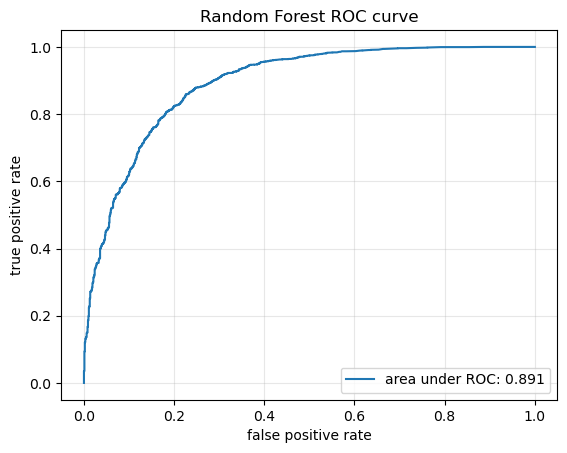

In [215]:
# plot ROC
fpr_rf, tpr_rf, _ = skm.roc_curve(Y_test1, best_model_prob_auc[:,1])

fig, ax = plt.subplots()
ax.grid(alpha=0.3)

ax.plot(fpr_rf, tpr_rf, label=f'area under ROC: {best_model_auc_auc:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('Random Forest ROC curve')

plt.show()

### 5.5 Classifiers comparison

The following plot shows all the ROC curves computed on the test set for the different classifiers trained with their best hyperparameters. We want to compare them in order to choose the best classifier for our physical task. 

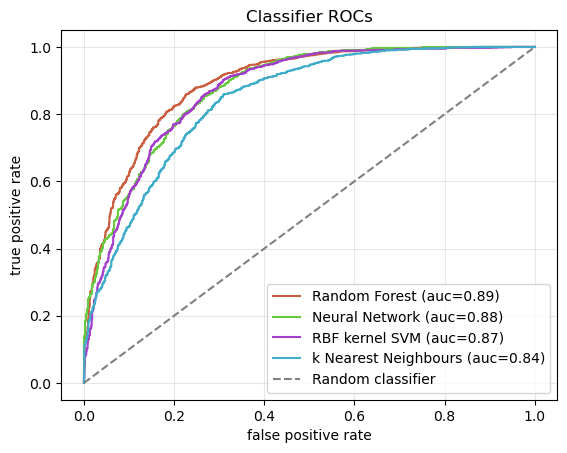

In [165]:
fig, ax = plt.subplots()
ax.grid(alpha = 0.3)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (auc={best_model_auc_auc:.2f})', color = '#ca5e3f')
ax.plot(fpr_NN, tpr_NN, label=f'Neural Network (auc={bestNNmodel_auc:.2f})', color = '#66ca3f')
ax.plot(fpr_RBF, tpr_RBF, label=f'RBF kernel SVM (auc={auc_RBF:.2f})', color = '#a33fca')
ax.plot(fpr_kNN, tpr_kNN, label=f'k Nearest Neighbours (auc={kNNauc_auc:.2f})', color = '#3facca')
ax.plot(fpr_kNN, fpr_kNN, label = 'Random classifier', linestyle = 'dashed', color = 'grey')

ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('Classifier ROCs')

plt.show()

The values of the area under the curve is close for all of them, but the one computed with Random Forest classifier is maximum. Since for our porpuse the best algorithm is the one that gives a larger area under the curve, the rest of the analysis will be performed using Random Forest classifier with the best parameters obtained before.

### 5.6 Best classifier: RF

From the comparison of the classifier ROCs, we established as best classifier the Random Forest. Now we want to analyze in detail and with more metrics the best classifier ROC. We estimate:
* $loacc$: we first calculate the true positive rate when the false positive rate is 0.01, 0.02 and 0.05, then we compute the mean of these three values.
* $hiacc$: we first calculate the true positive rate when the false positive rate is 0.1 and 0.2, then we compute the mean value of these two values.
* the significance, defined as $\sigma=\frac{S}{\sqrt{2B+S}}$, where $S=\epsilon_{\gamma}N_S$, with $\epsilon_{\gamma}$ as the true positive rate and $N_S$ the total number of signal events in the dataset, and $B=\epsilon_{h}N_b$, with $\epsilon_{h}$ as the false positive rate and $N_b$ the total number of background events in the dataset. We evaluate $\sigma$ when $\epsilon_{\gamma}=0.5$ (and we find in the ROC the correspondent value for $\epsilon_{h}$) and we define it as $\sigma_{0.5}$, then we compute also $\sigma_{max}$, that is the maximum value of $\sigma$ computed along the ROC.

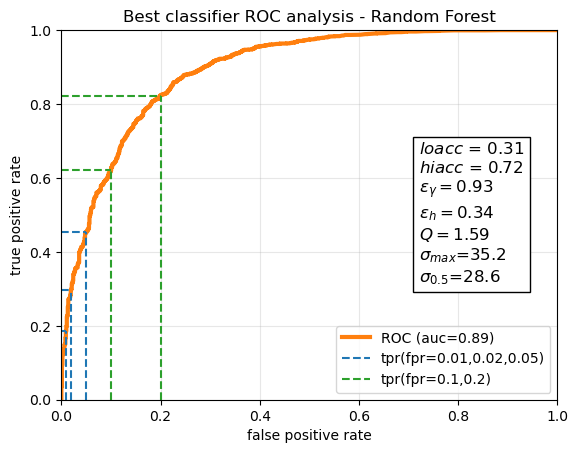

In [191]:
# analize RF ROC
def loacc(tp, fp):
    return (tp[np.argmin(np.abs(fp - 0.01))] + tp[np.argmin(np.abs(fp - 0.02))] + tp[np.argmin(np.abs(fp - 0.05))])/3

def hiacc(tp, fp):
    return (tp[np.argmin(np.abs(fp - 0.1))] + tp[np.argmin(np.abs(fp - 0.2))])/2

loacc_rf = loacc(tpr_rf, fpr_rf)
hiacc_rf = hiacc(tpr_rf, fpr_rf)

fig, ax = plt.subplots()
ax.grid(alpha = 0.3)

ax.plot(fpr_rf, tpr_rf, label=f'ROC (auc={best_model_auc_auc:.2f})', color = 'C1', linewidth=3)

# loacc data
ax.axhline(y=tpr_rf[np.argmin(np.abs(fpr_rf- 0.01))], xmin=0, xmax=0.01, color='C0',label=f'tpr(fpr=0.01,0.02,0.05)', linestyle='--')
ax.axvline(x=0.01, ymin=0, ymax=tpr_rf[np.argmin(np.abs(fpr_rf - 0.01))], color='C0', linestyle='--')

ax.axhline(y=tpr_rf[np.argmin(np.abs(fpr_rf - 0.02))], xmin=0, xmax=0.02, color='C0', linestyle='--')
ax.axvline(x=0.02, ymin=0, ymax=tpr_rf[np.argmin(np.abs(fpr_rf - 0.02))], color='C0', linestyle='--')

ax.axhline(y=tpr_rf[np.argmin(np.abs(fpr_rf - 0.05))], xmin=0, xmax=0.05, color='C0', linestyle='--')
ax.axvline(x=0.05, ymin=0, ymax=tpr_rf[np.argmin(np.abs(fpr_rf - 0.05))], color='C0', linestyle='--')

# hiacc data
ax.axhline(y=tpr_rf[np.argmin(np.abs(fpr_rf - 0.1))], xmin=0, xmax=0.1, color='C2', label=f'tpr(fpr=0.1,0.2)', linestyle='--')
ax.axvline(x=0.1, ymin=0, ymax=tpr_rf[np.argmin(np.abs(fpr_rf - 0.1))], color='C2', linestyle='--')

ax.axhline(y=tpr_rf[np.argmin(np.abs(fpr_rf - 0.2))], xmin=0, xmax=0.2, color='C2', linestyle='--')
ax.axvline(x=0.2, ymin=0, ymax=tpr_rf[np.argmin(np.abs(fpr_rf - 0.2))], color='C2', linestyle='--')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')

ax.set_title('Best classifier ROC analysis - Random Forest')
ax.legend(loc='lower right')

# significance
egamma = tpr_rf
ehadron = fpr_rf

S_max = freq_test1[1]*egamma
B_max = freq_test1[0]*ehadron
den_max = np.sqrt(2*B_max+S_max)
S_max = S_max[den_max!=0]
den_max = den_max[den_max!=0]
sigma_max = np.max(S_max/den_max)

S_half = freq_test1[1]*0.5
B_half = freq_test1[0]*fpr_rf[np.argmin(np.abs(tpr_rf-0.5))]
sigma_half = S_half/np.sqrt(2*B_half+S_half)

# text on plot
props = dict(facecolor='white')
textstr = '\n'.join((
    f'$loacc$ = {loacc_rf:.2f}',
    f'$hiacc$ = {hiacc_rf:.2f}',
    r'$\epsilon_{\gamma}=%.2f$' % (cm_RF[1][1]),
    r'$\epsilon_{h}=%.2f$' % (cm_RF[0][1]),
    r'$Q=%.2f$' % (bestRF_Q),
    r'$\sigma_{max}$=%.1f' % sigma_max,
    r'$\sigma_{0.5}$=%.1f' % sigma_half))
ax.text(0.72, 0.70, textstr, fontsize=12,
        verticalalignment='top', bbox=props)

plt.show()

The metrics we evaluated make more complete the performance evaluation of our classifier, since the Q-factor alone would not be sufficient in terms of evaluating the performance of the classifier with respect to the false positive rate. The values we obtained are sufficiently high to ensure a robust classification.

We then want to evaluate the feature importance for the Random Forest classifier and compare the two cases, one using `fAlpha` in training and another not using `fAlpha` in training. The feature importance is computed with the mean decrease in impurity from roots to leaves. This allows us to compare the importance of `fAlpha` and how this feature is relevant during classification.

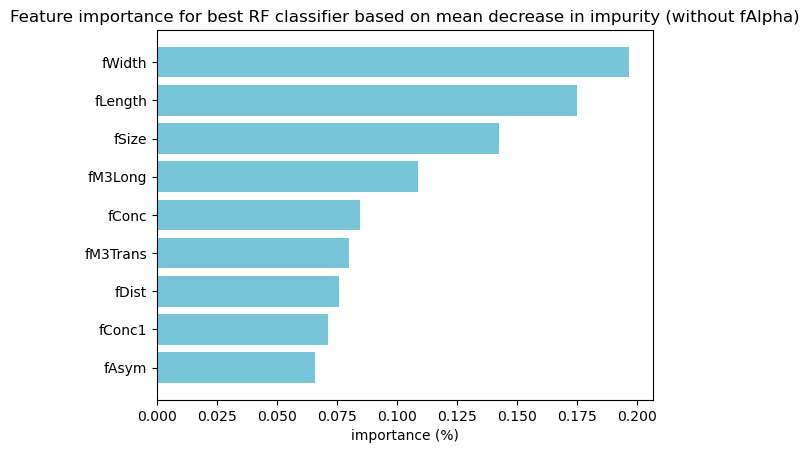

In [175]:
# feature importance in RF
sort = best_model_auc.feature_importances_.argsort()
plt.barh(X_train_no_alpha.columns[sort], best_model_auc.feature_importances_[sort], color='#3facca', alpha=0.7)
plt.title('Feature importance for best RF classifier based on mean decrease in impurity (without fAlpha)')
plt.xlabel('importance (%)')
plt.show()

In [45]:
# feature importance with Alpha
best_model_acc_alpha = RandomForestClassifier(n_estimators=best_trees_auc, max_depth=best_depth_auc) 
best_model_acc_alpha.fit(X_train, Y_train) 
best_model_pred_acc_alpha = best_model_acc_alpha.predict(X_test1)
best_model_prob_acc_alpha = best_model_acc_alpha.predict_proba(X_test1)

# accuracy and roc 
best_model_acc_acc_alpha = skm.accuracy_score(Y_test1, best_model_pred_acc_alpha)
print(f'Best random forest model accuracy with Alpha: {best_model_acc_acc_alpha:.3f}')
best_model_acc_auc_alpha = skm.roc_auc_score(Y_test1, best_model_prob_acc_alpha[:,1])
print(f'Best random forest model area under ROC with Alpha: {best_model_acc_auc_alpha:.3f}')

Best random forest model accuracy with Alpha: 0.890
Best random forest model area under ROC with Alpha: 0.938


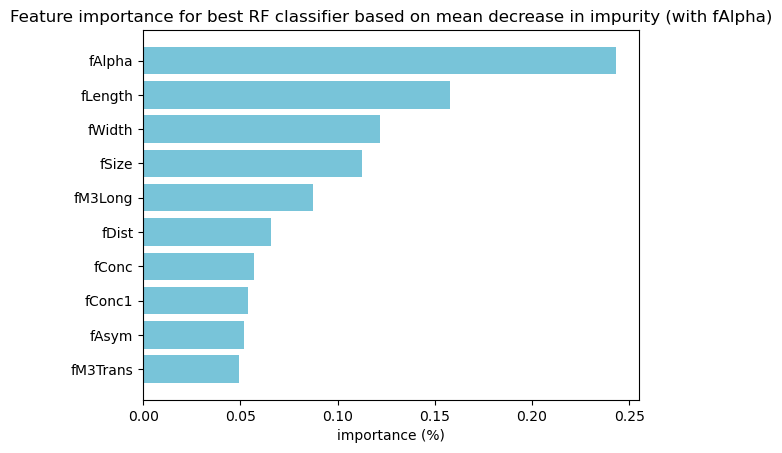

In [97]:
sort = best_model_acc_alpha.feature_importances_.argsort()
plt.barh(X_train.columns[sort], best_model_acc_alpha.feature_importances_[sort], color='#3facca', alpha=0.7) 
plt.xlabel('importance (%)')
plt.title('Feature importance for best RF classifier based on mean decrease in impurity (with fAlpha)')
plt.show()

Comparing the two cases, we can observe that as expected `fAlpha` retains the most importance, near 25%, and in both cases `fLength`, `fWidth` and `fSize` are the three most important features. We can also notice that the fourth most important feature is related to the asymmetry of the photon distribution in the camera plane, so we can conclude that the asymmetry of the trace is quite relevant to the classification task.

### 6. Acceptance threshold for signal events and alpha cuts in the datset

The objective of this section is to find the best values for the parameters Gammaness and Alpha Cut defined as follows:
* $gammaness$: discriminant parameter that measures the likelihood that an event originated from a primary gamma source;
* $alpha cut$: values of the parameter `fAlpha` used as treshold to select the data.\
The values of the angle alpha increases of 1° at each cut; for the gammaness values, instead, we consider a range from 0.6 to 0.9. We do not consider values larger than 0.9 since a threshold bigger than 0.9 would be a too strong requirement in our case not applicable in case of real data.\
To find the best values for these two parameters, we perform a grid search computing the value of Q for every point of the grid, looking for its highest value. For this computation we apply the best classifier again to "test 1".

In [47]:
# now we define n dataset with n = number of alpha cuts 
alpha_cut = np.arange(1,90,1)
alpha_set = []

for a in alpha_cut: 
    alpha_set.append([X_test1_no_alpha[X_test1['fAlpha']<= a], Y_test1[X_test1['fAlpha']<= a], a])

gammaness = np.arange(0.6,0.9,0.01)

In [48]:
# for each dataset we compute the quality factor of the best model for different values of gammaness
q_fact = []

for data_cut in alpha_set:

    prob = best_model_auc.predict_proba(data_cut[0])
    
    q_fact_gam = []

    for g in gammaness:
        prob_g = np.where(prob[:,1]>g,1,0)
        confusion_SVM = skm.confusion_matrix(data_cut[1], prob_g, normalize='true')
        if np.sqrt(confusion_SVM[0,1]) != 0:
            q = confusion_SVM[1,1]/np.sqrt(confusion_SVM[0,1])
            q_fact_gam.append(q)

    q_fact.append(q_fact_gam)

Best gammaness: 0.890
Best alpha cut: 7
Maximum Q value: 3.46


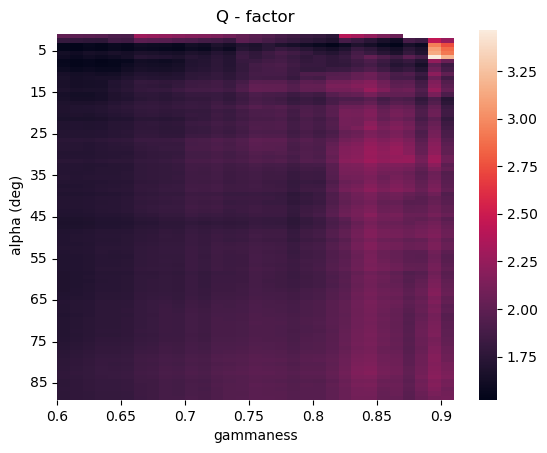

In [99]:
# plot
QQ = pd.DataFrame(q_fact, index=alpha_cut, columns=gammaness)

best_gammaness = QQ.max().idxmax()
best_q = QQ.max().max()
best_alphacut = QQ.max(axis='columns').idxmax()
print(f'Best gammaness: {best_gammaness:.3f}')
print('Best alpha cut:', best_alphacut)
print(f'Maximum Q value: {best_q:.2f}')

sns.heatmap(QQ, xticklabels='auto', yticklabels='auto')

plt.title('Q - factor')
plt.xlabel('gammaness')
plt.ylabel('alpha (deg)')
plt.xticks(ticks=range(0, len(gammaness), 5), labels=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9], rotation=0)
num_yticks = len(alpha_cut)
plt.yticks(ticks=range(5, num_yticks, 10), labels=range(5, num_yticks, 10)) 

plt.show()

The result obtained after the grid search is that the best gammaness treshold is 0.89, this means that we accept as gamma rays data labelled as signals by the classifier with a probability equal or larger than 89%. The best value of the angle alpha used to cut the data is 7°, a reasonable small value compatible with the `fAlpha` feature distribution of the signal, that is peacked on small angle values.

Setting this constrains, as can be seen in the confusion matrix, the majority of signal is labelled as background, but the false positive rate is very low and reasonably acceptable. To collect a sufficient amount of physical data is therefore necessary to collect large amounts of data.

Q factor: 2.03
Acceptance: 0.41%
False positive rate: 0.04%
False negative rate: 0.59%
Area under ROC: 0.897
Significance (max): 26.7
Significance (0.5): 19.6


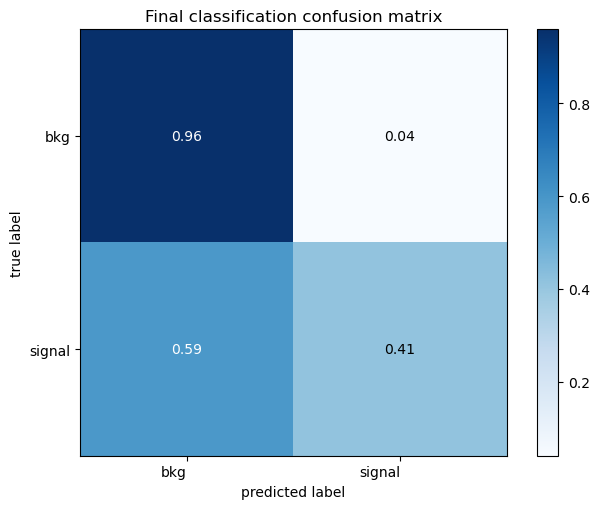

In [224]:
# apply result to test set 2
X_final = X_test2_no_alpha[X_test2['fAlpha']<=best_alphacut]
Y_final = Y_test2[X_test2['fAlpha']<=best_alphacut]

final_pred = best_model_auc.predict(X_final)
final_prob = best_model_auc.predict_proba(X_final)

final_pred = np.where(final_prob[:,1]>=best_gammaness, 1, 0)

final_acc = skm.accuracy_score(Y_final, final_pred)
final_auc = skm.roc_auc_score(Y_final, final_prob[:,1])

_, freq_final = np.unique(Y_final, return_counts=True)
cm_finall = skm.confusion_matrix(Y_final, final_pred)
cm_final = cm_finall/freq_final[:,None]
Q_final = cm_final[1][1]/np.sqrt(cm_final[0][1])
print(f'Q factor: {Q_final:.2f}')
print(f'Acceptance: {cm_final[1][1]:.2f}%')
print(f'False positive rate: {cm_final[0][1]:.2f}%')
print(f'False negative rate: {cm_final[1][0]:.2f}%')
print(f'Area under ROC: {skm.roc_auc_score(Y_final, final_prob[:,1]):.3f}')

# significance
fpr_final, tpr_final, _ = skm.roc_curve(Y_final, final_prob[:,1])
loacc_final = loacc(tpr_final, fpr_final)
hiacc_final = hiacc(tpr_final, fpr_final)
egamma_final = tpr_final
ehadron_final = fpr_final

S_max_final = freq_final[1]*egamma_final
B_max_final = freq_final[0]*ehadron_final
den_max_final = np.sqrt(2*B_max_final+S_max_final)
S_max_final = S_max_final[den_max_final!=0]
den_max_final = den_max_final[den_max_final!=0]
sigma_max_final = np.max(S_max_final/den_max_final)

S_half_final = freq_final[1]*0.5
B_half_final = freq_final[0]*fpr_final[np.argmin(np.abs(tpr_final-0.5))]
sigma_half_final = S_half_final/np.sqrt(2*B_half_final+S_half_final)
print(f'Significance (max): {sigma_max_final:.1f}')
print(f'Significance (0.5): {sigma_half_final:.1f}')

fig = plt.figure()

im_final = plt.imshow(cm_final, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_final.max() / 2.
for i in range(cm_final.shape[0]):
    for j in range(cm_final.shape[1]):
        plt.text(j, i, format(cm_final[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_final[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im_final, location = 'right') 
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Final classification confusion matrix')
plt.show()

We also computed the significance to make more complete the performance estimation and we obtain sufficiently high values for both $\sigma$.

At last we compute the total number of events classified as signal in the test set. This value is used in the next section to estimate the values of observation time.

In [149]:
# computing total number of events classified as gamma
n_gamma = cm_finall[0][1]+cm_finall[1][1]
print('Total number of event classified as gamma rays:', n_gamma)

Total number of event classified as gamma rays: 328


### 7. Observation time

Now we can compute the osbervation time we would need to have in order to get the results we got while observing the Crab Nebula instead. To do so we refer to the energy spectrum of the nebula measured by experiments HEGRA [4] and MAGIC [5], in particular we use the functions used in the article to fit the experimental spectrum along with the parameters of the best fit.
The energy spectrum is $\frac{dN}{dE}$ with $N=\frac{n_{\gamma}}{S\cdot\Delta t}$, where $S$ is the collection area of the telescope, assumed to be $10^9 cm^2$, $n_{\gamma}$ is the number of observed gammas (the sum of false and true positives coming from our best classificator, random forests) and $\Delta t$ is the observation time we want to estimate. It is clear that:
    
$\Delta t=\frac{n_{\gamma}}{S\cdot I}$ with $I=\int_{0.05 TeV}^{50 TeV} \frac{dN}{dE} dE$


### 7.1 HEGRA
Now the models used in [4] were: 
* the single power law:

$\frac{dN_{H}'}{dE}=f_{0_{H}}' \cdot (\frac{E}{E_0})^{-\alpha_{H}'}$

with $f_{0_{H}}'=(2.79\pm 0.02) \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$, $\alpha_{H}'=2.59\pm 0.03$, $E_0=1.0 TeV$

* the power law with the logarithmic correction on the exponent:

$\frac{dN_{H}''}{dE}=f_{0_{H}}'' \cdot (\frac{E}{E_0})^{-\alpha_{H}''+\beta_{H} log(\frac{E}{E_0})}$

with $f_{0_{H}}''=(2.67\pm 0.01) \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$, $\alpha_{H}''=2.47\pm 0.10$, $\beta_{H}=-0.11\pm 0.1$, $E_0=1.0 TeV$

Computing the two integrals we can see that the first is computable analitically:

$I_{H}'=\int f_{0_{H}}' \cdot (\frac{E}{E_0})^{-\alpha_{H}'} dE = \frac{E_0^\alpha \cdot f_0}{-\alpha_{H}'+1} \cdot E^{-\alpha_{H}'+1} $

while the second we integrate with scipy built in functions:

$I_{H}'' = \int_{0.05TeV}^{50TeV} f_{0_{H}}'' \cdot (\frac{E}{E_0})^{-\alpha_{H}''+\beta_{H} log(\frac{E}{E_0})}$

The errors on the estimated times were calculated according to the fitting parameters' errors given in the papers, for the analytical integral through a simple error propagation and for the scipy computed integral as the average of the integrals between the 'maximal curve', namely the curve whose parameters are augmented by a standard deviation, and the 'minimal curve', the curve whose parameters are diminished by a standard deviation; a propagation would have been more rigorous but a simpler method had to be used given how we computed such integral.

In [199]:
S=10**9 #cm^2
E0=1.0 #TeV
alphaH1err=un.ufloat(2.59,0.03)
alphaH1=2.59
alphaH2=2.47
betaH2=-0.11
f0H1err=un.ufloat(2.79*10**(-11),0.02*10**(-11)) #m^2 s^-1 TeV^-1
f0H1=2.79*10**(-11)
f0H2=2.67*10**(-11) #m^2 s^-1 TeV^-1
Emin=0.05 #TeV
Emax=50 #TeV
n_samples=2**20+1
E=np.linspace(Emin,Emax,2**20+1,endpoint=True)

mask1=(E>=1)
mask0=(E<1)

# first integral
def dN_sp(x,e0,alpha):
    return np.power(x/e0,-alpha)
I1const=((E0**alphaH1err)*f0H1err)/(-alphaH1err+1)
I1=I1const*(Emax**(-alphaH1err+1)-Emin**(-alphaH1err+1))
tH1=(n_gamma)/(S*I1)

# second integral
def dN_log(x,e0,alpha,beta):
    return np.power(x/e0,-alpha+beta*np.log(x/e0))

E01=np.linspace(Emin,1,n_samples,endpoint=False)
E1=np.linspace(1,Emax,n_samples,endpoint=True)

dE=E[1]-E[0]
dE1=E01[1]-E01[0]
dE2=E1[1]-E1[0]
I2=f0H2*integrate.romb(dN_log(E,E0,alphaH2,betaH2),dx=dE)

I2max=(f0H2+0.01*10**(-11))*(integrate.romb(dN_log(E01,E0,alphaH2-0.10,betaH2+0.1),dx=dE1)+integrate.romb(dN_log(E1,E0,alphaH2+0.10,betaH2+0.1),dx=dE2))
I2min=(f0H2-0.01*10**(-11))*(integrate.romb(dN_log(E01,E0,alphaH2+0.10,betaH2-0.1),dx=dE1)+integrate.romb(dN_log(E1,E0,alphaH2-0.10,betaH2-0.1),dx=dE2))
err=0.5*(I2max-I2min)
tH2=(n_gamma)/(S*I2)
th2err=(n_gamma*err)/(S*I2**2)
print('The Hegra observation times are:')
print(' - Single power law: {0} minutes'.format(tH1/60))
print(' - Power law with the logarithmic correction on the exponent: {0} \u00B1 {1} minutes'.format(np.round(tH2/60,2),np.round(th2err/60,2)))

The Hegra observation times are:
 - Single power law: 2.66+/-0.19 minutes
 - Power law with the logarithmic correction on the exponent: 6.73 ± 2.1 minutes


### 7.2 MAGIC
On the other hand the models used in [5] were:
* the power law with the exponential cutoff:

$\frac{dN_1}{dE}=f_{0_{MG}}' \cdot (\frac{E}{E_0})^{-\alpha_{MG}'} \cdot (e)^{-\frac{E}{E_C}}$

with $f_{0_{MG1}}'=(3.80\pm 0.11) \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$, $\alpha_{MG}'=2.21\pm 0.02$, $E_0=1.0 TeV$, $E_C=6.0\pm 0.6 TeV$

* the power law with the logarithmic correction on the exponent

$\frac{dN_2}{dE}=f_{0_{MG}}'' \cdot (\frac{E}{E_0})^{-\alpha_{MG}''+\beta log(\frac{E}{E_0})}$

with $f_{0_{MG}}''=(3.23\pm0.03) \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$, $\alpha_{MG}''=2.47\pm 0.01$, $\beta = -0.24\pm 0.01$, $E_0=1.0 TeV$

We compute both integral with the built in functions of scipy:

$I_1 = \int_{0.05TeV}^{50TeV} f_{0_{MG}}' \cdot (\frac{E}{E_0})^{-\alpha_{MG}'} \cdot (e)^{-\frac{E}{E_C}} $

$I_2 = \int_{0.05TeV}^{50TeV} f_{0_{MG}}'' \cdot (\frac{E}{E_0})^{-\alpha_{MG}''+\beta log(\frac{E}{E_0})}$

The observation time errors where estimated in the same fashion as the scipy computed integral of the last section.

In [201]:
alphaM1=2.21
alphaM2=2.47
betaM2=-0.24
f0M1=3.8*10**(-11) #m^2 s^-1 TeV^-1
f0M2=3.23*10**(-11) #m^2 s^-1 TeV^-1
Ec=6 #TeV

#First integral
def dN_exp(x,e0,alpha,ec):
    return (x/e0)**(-alpha)*np.exp(-x/ec)

I1=f0M1*integrate.romb(dN_exp(E,E0,alphaM1,Ec),dx=dE)
I1max=(f0M1+0.11*10**(-11))*(integrate.romb(dN_exp(E,E0,alphaM1-0.02,Ec-0.6),dx=dE1)+integrate.romb(dN_exp(E,E0,alphaM1+0.02,Ec-0.6),dx=dE2))
I1min=(f0M1-0.11*10**(-11))*(integrate.romb(dN_exp(E,E0,alphaM1+0.02,Ec+0.6),dx=dE1)+integrate.romb(dN_exp(E,E0,alphaM1-0.02,Ec+0.6),dx=dE2))
err1=0.5*(I1max-I1min)
thM1err=(n_gamma*err1)/(S*I1**2)
tM1=(n_gamma)/(S*I1)

#Second integral
I2=f0M2*integrate.romb(dN_log(E,E0,alphaM2,betaM2),dx=dE)
I2max=(f0M2+0.03*10**(-11))*(integrate.romb(dN_log(E01,E0,alphaM2-0.01,betaM2+0.01),dx=dE1)+integrate.romb(dN_log(E1,E0,alphaM2+0.01,betaM2+0.01),dx=dE2))
I2min=(f0M2-0.03*10**(-11))*(integrate.romb(dN_log(E01,E0,alphaM2+0.01,betaM2-0.01),dx=dE1)+integrate.romb(dN_log(E1,E0,alphaM2-0.01,betaM2-0.01),dx=dE2))
err2=0.5*(I2max-I2min)
tM2=(n_gamma)/(S*I2)
thM2err=(n_gamma*err2)/(S*I2**2)

print('The MAGIC observation times are:')
print(' - Power law with the exponential cutoff: {0} \u00B1 {1} minutes '.format(np.round(tM1/60,2),np.round(thM1err/60,2)))
print(' - Power law with the logarithmic correction on the exponent: {0} \u00B1 {1} minutes'.format(np.round(tM2/60,2),np.round(thM2err/60,2)))


The MAGIC observation times are:
 - Power law with the exponential cutoff: 4.79 ± 0.33 minutes 
 - Power law with the logarithmic correction on the exponent: 10.23 ± 0.33 minutes


### 7.3 Spectra comparison

Lastly we plot the papers' fitting functions in order to see how their differences can explain the different times and errors we estimated. Firstly we can assess that all 4 functions converge in the middle of our energy range, but diverge on the edges. It is clear that an overall bigger integral correlates to a smaller observation time. 
Curves with bigger errors obviously render greater errors in the observation times, as we can see for the HEGRA's power law with logarithmic correction on the exponent.
If we were to choose a power law that best fits our data we would probably opt for a model from [5], as they work really well in a range (50 GeV-30 TeV) more similar to our energy range, whereas models in [4] work satisfyingly only from around 1 to 20 TeV.

The final times of observation are:
 - HEGRA Single power law: 2.66+/-0.19 minutes
 - MAGIC Power law with the exponential cutoff: 4.79 ± 0.33 minutes 
 - HEGRA Power law with the logarithmic correction on the exponent: 6.73 ± 2.1 minutes
 - MAGIC Power law with the logarithmic correction on the exponent: 10.23 ± 0.33 minutes


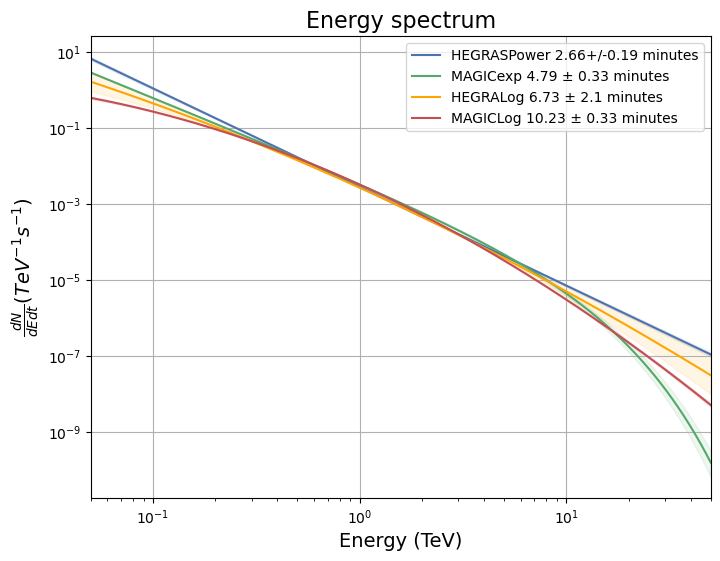

In [227]:
print('The final times of observation are:')
print(' - HEGRA Single power law: {0} minutes'.format(tH1/60))
print(' - MAGIC Power law with the exponential cutoff: {0} \u00B1 {1} minutes '.format(np.round(tM1/60,2),np.round(thM1err/60,2)))
print(' - HEGRA Power law with the logarithmic correction on the exponent: {0} \u00B1 {1} minutes'.format(np.round(tH2/60,2),np.round(th2err/60,2)))
print(' - MAGIC Power law with the logarithmic correction on the exponent: {0} \u00B1 {1} minutes'.format(np.round(tM2/60,2),np.round(thM2err/60,2)))


fig,ax=plt.subplots(figsize=(8,6))
ax.plot(E,(10**8)*f0H1*dN_sp(E,E0,alphaH1),label='HEGRASPower {0} minutes'.format(tH1/60),color='b')


ax.plot(E,(10**8)*f0M1*dN_exp(E,E0,alphaM1,Ec),label='MAGICexp {0} \u00B1 {1} minutes '.format(np.round(tM1/60,2),np.round(thM1err/60,2)),color='g')
ax.plot(E,(10**8)*f0H2*dN_log(E,E0,alphaH2,betaH2),label='HEGRALog {0} \u00B1 {1} minutes'.format(np.round(tH2/60,2),np.round(th2err/60,2)),color='orange')

ax.plot(E,(10**8)*f0M2*dN_log(E,E0,alphaM2,betaM2),label='MAGICLog {0} \u00B1 {1} minutes'.format(np.round(tM2/60,2),np.round(thM2err/60,2)),color='r')

ax.fill_between(E[mask0], (10**8)*(f0H1-(0.02*10**(-11)))*dN_sp(E[mask0],E0,alphaH1-0.03),(10**8)*(f0H1+(0.02*10**(-11)))*dN_sp(E[mask0],E0,alphaH1+0.03), color='b', alpha=0.1)
ax.fill_between(E[mask1], (10**8)*(f0H1-(0.02*10**(-11)))*dN_sp(E[mask1],E0,alphaH1+0.03),(10**8)*(f0H1+(0.02*10**(-11)))*dN_sp(E[mask1],E0,alphaH1-0.03), color='b', alpha=0.1)

ax.fill_between(E[mask0], (10**8)*(f0H2-0.01*10**(-11))*dN_log(E[mask0],E0,alphaH2+0.10,betaH2-0.1),(10**8)*(f0H2+0.01*10**(-11))*dN_log(E[mask0],E0,alphaH2-0.10,betaH2+0.1), color='orange', alpha=0.1)
ax.fill_between(E[mask1], (10**8)*(f0H2-0.01*10**(-11))*dN_log(E[mask1],E0,alphaH2-0.10,betaH2-0.1),(10**8)*(f0H2+0.01*10**(-11))*dN_log(E[mask1],E0,alphaH2+0.10,betaH2+0.1), color='orange', alpha=0.1)


ax.fill_between(E[mask0], (10**8)*(f0M1-0.11*10**(-11))*dN_exp(E[mask0],E0,alphaM1+0.02,Ec-0.6),(10**8)*(f0M1+0.11*10**(-11))*dN_exp(E[mask0],E0,alphaM1-0.02,Ec+0.6), color='g', alpha=0.1)
ax.fill_between(E[mask1], (10**8)*(f0M1-0.11*10**(-11))*dN_exp(E[mask1],E0,alphaM1-0.02,Ec-0.6),(10**8)*(f0M1+0.11*10**(-11))*dN_exp(E[mask1],E0,alphaM1+0.02,Ec+0.6), color='g', alpha=0.1)

ax.fill_between(E[mask0], (10**8)*(f0M2-0.03*10**(-11))*dN_log(E[mask0],E0,alphaM2+0.01,betaM2-0.01),(10**8)*(f0M2+0.03*10**(-11))*dN_log(E[mask0],E0,alphaM2-0.01,betaM2+0.01), color='r', alpha=0.1)
ax.fill_between(E[mask1], (10**8)*(f0M2-0.03*10**(-11))*dN_log(E[mask1],E0,alphaM2-0.01,betaM2-0.01),(10**8)*(f0M2+0.03*10**(-11))*dN_log(E[mask1],E0,alphaM2+0.01,betaM2+0.01), color='r', alpha=0.1)

ax.semilogx()
ax.semilogy()
ax.set_title('Energy spectrum',fontsize=16)
ax.set_xlabel('Energy (TeV)',fontsize=14)
ax.set_ylabel(r'$\frac{dN}{dEdt} (TeV^{-1} s^{-1})$',fontsize=14)
ax.set_xlim([Emin, Emax])
ax.legend(loc='best')
ax.grid()

plt.show()